# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
import sys
sys.path.append("code")

from unityagents import UnityEnvironment
import numpy as np
import random as random
import torch

import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

In [5]:
from collections import deque

episode_actions = []
def ddpg(agent, env, solved_threshold, n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        episode_actions.append([])
        for t in range(max_t):
            action = agent.act(state)
            episode_actions[-1].append(action)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if t % 20:
                print('\rTimestep {}\tScore: {:.2f}'.format(t, score), end="") 
            if done:
                break 
        
        scores.append(score)
        scores_deque.append(score)
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tActions: {}'.format(i_episode, score, np.mean(scores_deque), action), end="\n")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque) >= solved_threshold:
            print('\rEnvironment solved in {} episodes!'.format(i_episode))
            
    return scores


In [6]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

print('Number of agents:', num_agents)
print("State size:  {}".format(state_size))
print("Action size: {}".format(action_size))
print("Layers: {} - {} - {}".format(state_size, '?', action_size))

Number of agents: 1
State size:  33
Action size: 4
Layers: 33 - ? - 4


In [12]:
from DDPGAgent import DDPGAgent

agent = DDPGAgent(state_size, action_size)
scores = ddpg(agent, env, 30, 2000, 500)

Episode 1	Score: 0.00	Average Score: 0.00	Actions: [0.07635248 1.         0.11754184 0.39874867]
Episode 2	Score: 0.00	Average Score: 0.00	Actions: [-0.04849473  0.09096225  0.8331012  -0.43092224]
Episode 3	Score: 0.21	Average Score: 0.07	Actions: [-0.2892711  1.        -0.5059482  1.       ]
Episode 4	Score: 0.07	Average Score: 0.07	Actions: [-0.43256444  1.         -0.37041008  0.8658532 ]
Episode 5	Score: 0.05	Average Score: 0.07	Actions: [-0.4641539  0.6537547  0.7927042  0.6067303]
Episode 6	Score: 1.06	Average Score: 0.23	Actions: [-0.03074938  1.          1.         -0.21472974]
Episode 7	Score: 0.31	Average Score: 0.24	Actions: [-0.2129053   1.         -0.37655085  0.91255987]
Episode 8	Score: 0.00	Average Score: 0.21	Actions: [ 1.          0.35998586  1.         -0.23439053]
Episode 9	Score: 0.20	Average Score: 0.21	Actions: [ 1.          1.         -0.22310507 -0.28410092]
Episode 10	Score: 0.00	Average Score: 0.19	Actions: [-0.19450875 -0.33886158  1.         -0.22113067]
E

Episode 82	Score: 0.00	Average Score: 0.31	Actions: [ 1.         1.         1.        -0.4908872]
Episode 83	Score: 0.07	Average Score: 0.31	Actions: [ 1.         -0.23395044  1.         -0.21682733]
Episode 84	Score: 0.24	Average Score: 0.31	Actions: [ 1.         1.        -0.2692599  1.       ]
Episode 85	Score: 0.26	Average Score: 0.31	Actions: [ 0.78075224 -0.1487171   1.         -0.4329464 ]
Episode 86	Score: 0.60	Average Score: 0.31	Actions: [ 1.          1.          0.8859038  -0.20161963]
Episode 87	Score: 0.00	Average Score: 0.31	Actions: [-0.2844758   1.          0.00984744  0.00267085]
Episode 88	Score: 0.00	Average Score: 0.30	Actions: [1.         0.68350077 1.         1.        ]
Episode 89	Score: 0.00	Average Score: 0.30	Actions: [ 1.         -0.40108654  1.         -0.42926672]
Episode 90	Score: 0.16	Average Score: 0.30	Actions: [-0.3020221   1.         -0.30957612 -0.2552418 ]
Episode 91	Score: 0.00	Average Score: 0.30	Actions: [-0.18536042 -0.06207824  1.         -0.51

Episode 164	Score: 0.09	Average Score: 0.20	Actions: [ 1.         -0.20361446 -0.1951198   1.        ]
Episode 165	Score: 0.15	Average Score: 0.20	Actions: [ 0.2841066   1.          1.         -0.44451872]
Episode 166	Score: 0.00	Average Score: 0.20	Actions: [ 0.5928638   1.         -0.10828988  1.        ]
Episode 167	Score: 0.37	Average Score: 0.20	Actions: [-0.39520136  0.8010711  -0.07319511 -0.36839795]
Episode 168	Score: 0.46	Average Score: 0.21	Actions: [ 1.          1.         -0.20283684 -0.23532234]
Episode 169	Score: 0.49	Average Score: 0.21	Actions: [ 1.          0.36802214 -0.3525391   0.00575236]
Episode 170	Score: 0.00	Average Score: 0.21	Actions: [-0.23122653  0.2529954   1.          1.        ]
Episode 171	Score: 0.54	Average Score: 0.21	Actions: [ 1.          0.09954453 -0.30073825 -0.361925  ]
Episode 172	Score: 0.13	Average Score: 0.21	Actions: [ 0.06353994  0.4043302  -0.38379574 -0.56496614]
Episode 173	Score: 0.17	Average Score: 0.21	Actions: [-0.1980008  1.     

Episode 245	Score: 0.85	Average Score: 0.53	Actions: [-0.28656742  1.         -0.648967   -0.28659174]
Episode 246	Score: 0.55	Average Score: 0.53	Actions: [1. 1. 1. 1.]
Episode 247	Score: 0.32	Average Score: 0.53	Actions: [ 1.          0.81222385  1.         -0.33151793]
Episode 248	Score: 0.84	Average Score: 0.53	Actions: [1. 1. 1. 1.]
Episode 249	Score: 0.48	Average Score: 0.53	Actions: [-0.34170604  1.         -0.12573297  1.        ]
Episode 250	Score: 0.27	Average Score: 0.53	Actions: [ 1.         1.         1.        -0.2504276]
Episode 251	Score: 0.05	Average Score: 0.53	Actions: [ 0.2231706  1.         1.        -0.1785382]
Episode 252	Score: 0.14	Average Score: 0.52	Actions: [ 1.          1.         -0.47621107  1.        ]
Episode 253	Score: 0.36	Average Score: 0.52	Actions: [ 1.          1.          1.         -0.52189606]
Episode 254	Score: 0.53	Average Score: 0.53	Actions: [-0.3614867   1.          1.         -0.34938115]
Episode 255	Score: 0.07	Average Score: 0.52	Action

Episode 326	Score: 0.87	Average Score: 0.49	Actions: [-0.42711323 -0.46086124 -0.14342636 -0.4606011 ]
Episode 327	Score: 0.41	Average Score: 0.48	Actions: [-0.36133108  0.20154731  1.         -0.5154666 ]
Episode 328	Score: 0.93	Average Score: 0.48	Actions: [-0.23454861  1.          1.         -0.3491895 ]
Episode 329	Score: 1.33	Average Score: 0.49	Actions: [-0.1862979  -0.11090023  1.          1.        ]
Episode 330	Score: 0.39	Average Score: 0.48	Actions: [-0.4393692  1.         1.         1.       ]
Episode 331	Score: 0.17	Average Score: 0.48	Actions: [-0.5575329  -0.3918625  -0.47104087  0.27980357]
Episode 332	Score: 0.81	Average Score: 0.48	Actions: [ 0.16170579  1.          0.00608408 -0.4216427 ]
Episode 333	Score: 0.97	Average Score: 0.49	Actions: [-0.2543824  -0.01121645 -0.06485457 -0.18731354]
Episode 334	Score: 0.00	Average Score: 0.49	Actions: [-0.44942403 -0.05069144  1.          0.99856675]
Episode 335	Score: 1.03	Average Score: 0.50	Actions: [-0.34667006 -0.45322427

Episode 406	Score: 0.56	Average Score: 0.45	Actions: [-0.4255152   1.          1.         -0.42913362]
Episode 407	Score: 1.55	Average Score: 0.46	Actions: [ 1.         -0.1553184  -0.24384364  1.        ]
Episode 408	Score: 0.56	Average Score: 0.46	Actions: [ 1.          1.         -0.2591971  -0.43579555]
Episode 409	Score: 0.17	Average Score: 0.46	Actions: [ 1.         -0.25256026  1.         -0.5138099 ]
Episode 410	Score: 0.50	Average Score: 0.45	Actions: [ 1.          1.         -0.15330864 -0.31195083]
Episode 411	Score: 0.52	Average Score: 0.46	Actions: [ 0.8788769   1.         -0.2876161  -0.02579194]
Episode 412	Score: 1.12	Average Score: 0.47	Actions: [-0.37694958 -0.25141948  1.         -0.31854686]
Episode 413	Score: 0.54	Average Score: 0.47	Actions: [-0.4925366  -0.20646118 -0.3186315   1.        ]
Episode 414	Score: 0.63	Average Score: 0.47	Actions: [-0.483103   -0.3479578  -0.37156105 -0.02230027]
Episode 415	Score: 0.00	Average Score: 0.47	Actions: [-0.15330206  1.    

Episode 486	Score: 0.00	Average Score: 0.51	Actions: [ 1.          1.          0.483852   -0.25628915]
Episode 487	Score: 0.65	Average Score: 0.52	Actions: [ 1.          0.92841816 -0.171414   -0.29594535]
Episode 488	Score: 0.53	Average Score: 0.52	Actions: [ 1.         -0.06649314  1.          0.508578  ]
Episode 489	Score: 0.22	Average Score: 0.51	Actions: [-0.39075     1.          1.         -0.18870963]
Episode 490	Score: 0.26	Average Score: 0.51	Actions: [-0.4162706   1.         -0.06480899  0.5522808 ]
Episode 491	Score: 0.51	Average Score: 0.52	Actions: [-0.2916041  1.         1.         1.       ]
Episode 492	Score: 0.32	Average Score: 0.51	Actions: [ 1.          1.          1.         -0.38741183]
Episode 493	Score: 0.33	Average Score: 0.51	Actions: [-0.44159102  1.          1.         -0.402088  ]
Episode 494	Score: 0.58	Average Score: 0.51	Actions: [-0.38572267 -0.29682255  1.          1.        ]
Episode 495	Score: 0.00	Average Score: 0.51	Actions: [-0.4130102  -0.28815186

Episode 566	Score: 0.57	Average Score: 0.74	Actions: [-0.34604165  1.          1.         -0.31444395]
Episode 567	Score: 0.48	Average Score: 0.73	Actions: [-0.27865124 -0.2684076   1.         -0.31648332]
Episode 568	Score: 0.41	Average Score: 0.73	Actions: [-0.43112877 -0.30627537  1.         -0.24810809]
Episode 569	Score: 0.81	Average Score: 0.73	Actions: [-0.29320338  0.18075956 -0.17825525 -0.47595266]
Episode 570	Score: 1.22	Average Score: 0.74	Actions: [0.06314445 1.         1.         1.        ]
Episode 571	Score: 1.89	Average Score: 0.75	Actions: [-0.42589384  1.         -0.16707699  1.        ]
Episode 572	Score: 1.33	Average Score: 0.76	Actions: [-0.2967031  1.         1.         1.       ]
Episode 573	Score: 0.18	Average Score: 0.77	Actions: [ 1.          1.         -0.25048155 -0.5155763 ]
Episode 574	Score: 0.00	Average Score: 0.75	Actions: [-0.27952394 -0.32699504  1.          0.02081506]
Episode 575	Score: 3.56	Average Score: 0.78	Actions: [-0.44991648  1.         -0.

Episode 646	Score: 0.12	Average Score: 0.80	Actions: [1. 1. 1. 1.]
Episode 647	Score: 0.73	Average Score: 0.79	Actions: [ 1.          1.         -0.39369947 -0.24098136]
Episode 648	Score: 0.13	Average Score: 0.79	Actions: [1. 1. 1. 1.]
Episode 649	Score: 1.88	Average Score: 0.80	Actions: [-0.28153554  1.         -0.3066269  -0.32778442]
Episode 650	Score: 0.48	Average Score: 0.80	Actions: [-0.30847013  1.          1.          1.        ]
Episode 651	Score: 0.68	Average Score: 0.80	Actions: [ 1.        1.        1.       -0.433529]
Episode 652	Score: 1.09	Average Score: 0.80	Actions: [-0.32700077  1.          1.          1.        ]
Episode 653	Score: 0.29	Average Score: 0.80	Actions: [-0.4744213  -0.21663044  1.         -0.33489114]
Episode 654	Score: 0.73	Average Score: 0.78	Actions: [ 1.         -0.18640618  1.         -0.38260204]
Episode 655	Score: 0.52	Average Score: 0.78	Actions: [ 1.          0.27834797 -0.37609908 -0.20923606]
Episode 656	Score: 0.29	Average Score: 0.78	Action

Episode 727	Score: 0.22	Average Score: 0.89	Actions: [-0.48938406  1.         -0.5071041  -0.47419545]
Episode 728	Score: 1.22	Average Score: 0.89	Actions: [-0.3829602   1.          0.90900105 -0.3558327 ]
Episode 729	Score: 0.45	Average Score: 0.88	Actions: [-0.42005864  1.          1.         -0.48905897]
Episode 730	Score: 0.59	Average Score: 0.88	Actions: [-0.36394483  0.8900798   1.         -0.25617522]
Episode 731	Score: 0.74	Average Score: 0.87	Actions: [-0.17911175 -0.2546919  -0.22970466 -0.35134977]
Episode 732	Score: 0.62	Average Score: 0.87	Actions: [-0.38591525  1.         -0.66052645 -0.518669  ]
Episode 733	Score: 0.48	Average Score: 0.87	Actions: [-0.06193264  1.         -0.05517938 -0.36280513]
Episode 734	Score: 0.96	Average Score: 0.87	Actions: [ 1.          1.          1.         -0.28361446]
Episode 735	Score: 0.42	Average Score: 0.87	Actions: [ 0.56831604  1.         -0.43128332 -0.28418073]
Episode 736	Score: 1.37	Average Score: 0.87	Actions: [-0.34585828 -0.4414

Episode 807	Score: 1.21	Average Score: 0.82	Actions: [-0.3835262   1.         -0.01109529 -0.2201324 ]
Episode 808	Score: 0.89	Average Score: 0.82	Actions: [-0.28605407  1.          1.         -0.1668694 ]
Episode 809	Score: 0.42	Average Score: 0.82	Actions: [-0.33045498  1.         -0.34504506 -0.49290168]
Episode 810	Score: 1.85	Average Score: 0.82	Actions: [ 1.          1.         -0.23406816 -0.5001314 ]
Episode 811	Score: 0.56	Average Score: 0.83	Actions: [ 0.8639879   1.          0.90695375 -0.5193873 ]
Episode 812	Score: 2.25	Average Score: 0.84	Actions: [-0.24463421  1.         -0.53785485 -0.27941456]
Episode 813	Score: 2.26	Average Score: 0.86	Actions: [-0.453316    1.         -0.5888453  -0.42641222]
Episode 814	Score: 0.88	Average Score: 0.86	Actions: [-0.35601106  1.         -0.321117   -0.513866  ]
Episode 815	Score: 0.73	Average Score: 0.87	Actions: [-0.50305134  1.         -0.20087257 -0.23751658]
Episode 816	Score: 1.05	Average Score: 0.86	Actions: [-0.04751293  1.    

Episode 887	Score: 0.59	Average Score: 1.07	Actions: [-0.31723064  1.         -0.27041742 -0.30670998]
Episode 888	Score: 0.82	Average Score: 1.06	Actions: [ 1.         -0.1951629   1.         -0.33105138]
Episode 889	Score: 0.86	Average Score: 1.06	Actions: [-0.26181826  1.         -0.31421822 -0.3360355 ]
Episode 890	Score: 1.79	Average Score: 1.07	Actions: [-0.396376    1.         -0.31659457 -0.23390602]
Episode 891	Score: 0.70	Average Score: 1.07	Actions: [-0.24791637  1.         -0.09659389 -0.17537065]
Episode 892	Score: 0.57	Average Score: 1.07	Actions: [ 1.         -0.27853614 -0.35698664  1.        ]
Episode 893	Score: 0.33	Average Score: 1.06	Actions: [-0.23778778  1.         -0.3113406  -0.16664451]
Episode 894	Score: 2.48	Average Score: 1.07	Actions: [1. 1. 1. 1.]
Episode 895	Score: 1.47	Average Score: 1.08	Actions: [-0.20738877  1.          1.         -0.22559358]
Episode 896	Score: 1.74	Average Score: 1.10	Actions: [-0.30597076  1.         -0.20894971 -0.41101262]
Episod

Episode 967	Score: 0.00	Average Score: 1.18	Actions: [ 1.         -0.46146837  1.         -0.21541971]
Episode 968	Score: 1.07	Average Score: 1.19	Actions: [ 0.11207491  0.778948    1.         -0.34990278]
Episode 969	Score: 0.76	Average Score: 1.19	Actions: [ 1.          1.         -0.30302605  0.1596376 ]
Episode 970	Score: 0.42	Average Score: 1.19	Actions: [-0.18161227  1.         -0.16203114 -0.15242973]
Episode 971	Score: 0.58	Average Score: 1.19	Actions: [-0.36538902 -0.20298609  1.         -0.46996248]
Episode 972	Score: 1.65	Average Score: 1.18	Actions: [ 1.         1.         1.        -0.3964512]
Episode 973	Score: 2.24	Average Score: 1.19	Actions: [ 1.          1.          1.         -0.30892858]
Episode 974	Score: 1.33	Average Score: 1.18	Actions: [-0.27500275  1.          1.         -0.26778823]
Episode 975	Score: 0.59	Average Score: 1.16	Actions: [ 1.          1.          1.         -0.48849493]
Episode 976	Score: 0.86	Average Score: 1.16	Actions: [-0.3012655   1.        

Episode 1047	Score: 0.46	Average Score: 1.09	Actions: [ 1.          1.         -0.24930464 -0.3233583 ]
Episode 1048	Score: 0.10	Average Score: 1.08	Actions: [-0.31929204  1.         -0.34350762  1.        ]
Episode 1049	Score: 0.84	Average Score: 1.08	Actions: [-0.13784285 -0.19200718 -0.33075553  1.        ]
Episode 1050	Score: 1.09	Average Score: 1.08	Actions: [ 1.          1.          1.         -0.26693636]
Episode 1051	Score: 1.67	Average Score: 1.08	Actions: [1. 1. 1. 1.]
Episode 1052	Score: 0.32	Average Score: 1.07	Actions: [-0.29191977  1.         -0.5292946   1.        ]
Episode 1053	Score: 0.00	Average Score: 1.06	Actions: [ 1.          0.03886729  1.         -0.21017702]
Episode 1054	Score: 1.00	Average Score: 1.06	Actions: [-0.4234293   1.          0.47609973 -0.23287638]
Episode 1055	Score: 0.94	Average Score: 1.05	Actions: [1.         1.         0.08764971 1.        ]
Episode 1056	Score: 0.25	Average Score: 1.03	Actions: [-0.25570753 -0.28393915 -0.19446205 -0.3792743 ]


Episode 1128	Score: 1.76	Average Score: 1.12	Actions: [-0.08971664  1.         -0.36378288 -0.3818015 ]
Episode 1129	Score: 1.11	Average Score: 1.13	Actions: [-0.30633897 -0.35616916 -0.25498632 -0.45096007]
Episode 1130	Score: 1.81	Average Score: 1.15	Actions: [-0.27696788  1.          1.          1.        ]
Episode 1131	Score: 2.89	Average Score: 1.16	Actions: [-0.44749147  1.         -0.3828729  -0.26878273]
Episode 1132	Score: 1.21	Average Score: 1.15	Actions: [-0.22771749  1.         -0.12351592  1.        ]
Episode 1133	Score: 0.00	Average Score: 1.15	Actions: [ 1.          1.         -0.12757623 -0.21184404]
Episode 1134	Score: 1.98	Average Score: 1.15	Actions: [ 1.         -0.52085394 -0.35407054 -0.32137296]
Episode 1135	Score: 0.42	Average Score: 1.16	Actions: [ 1.          1.          0.43322408 -0.44423577]
Episode 1136	Score: 0.42	Average Score: 1.15	Actions: [ 1.          1.          1.         -0.13742064]
Episode 1137	Score: 1.06	Average Score: 1.13	Actions: [-0.346435

Episode 1207	Score: 1.19	Average Score: 1.24	Actions: [1. 1. 1. 1.]
Episode 1208	Score: 1.72	Average Score: 1.24	Actions: [-0.17682788 -0.37702447 -0.16006814  1.        ]
Episode 1209	Score: 0.84	Average Score: 1.22	Actions: [-0.39157468  1.         -0.5179814  -0.20959567]
Episode 1210	Score: 0.68	Average Score: 1.22	Actions: [ 1.         1.         1.        -0.5126222]
Episode 1211	Score: 1.13	Average Score: 1.23	Actions: [ 1.          0.5990253   1.         -0.40748954]
Episode 1212	Score: 0.49	Average Score: 1.22	Actions: [-0.62993073  1.          1.          1.        ]
Episode 1213	Score: 1.60	Average Score: 1.20	Actions: [-0.30182025 -0.4138007   1.         -0.41738918]
Episode 1214	Score: 0.38	Average Score: 1.19	Actions: [-0.387529   -0.27010688 -0.3193188  -0.07406156]
Episode 1215	Score: 0.92	Average Score: 1.17	Actions: [-0.32390118  1.         -0.4696173  -0.38018584]
Episode 1216	Score: 0.34	Average Score: 1.16	Actions: [-0.19305132 -0.34655163  1.         -0.39364555]


Episode 1287	Score: 1.69	Average Score: 1.13	Actions: [ 1.         -0.33211648 -0.31759316  0.5380142 ]
Episode 1288	Score: 3.43	Average Score: 1.14	Actions: [-0.32421505 -0.41892153 -0.25541586  1.        ]
Episode 1289	Score: 2.01	Average Score: 1.13	Actions: [ 1.         0.5058899  1.        -0.2770608]
Episode 1290	Score: 3.07	Average Score: 1.15	Actions: [ 1.         -0.42746493  0.49976346 -0.36883745]
Episode 1291	Score: 2.54	Average Score: 1.17	Actions: [ 1.          1.         -0.19946584  1.        ]
Episode 1292	Score: 2.13	Average Score: 1.18	Actions: [ 1.          0.48907796 -0.29458532 -0.13176088]
Episode 1293	Score: 2.15	Average Score: 1.16	Actions: [ 1.         -0.39431468  1.         -0.4803248 ]
Episode 1294	Score: 0.52	Average Score: 1.16	Actions: [ 1.          1.         -0.13952711 -0.28013027]
Episode 1295	Score: 2.74	Average Score: 1.18	Actions: [-0.25529006  1.          1.         -0.49582663]
Episode 1296	Score: 1.00	Average Score: 1.18	Actions: [ 1.         -

Episode 1366	Score: 1.22	Average Score: 1.42	Actions: [-0.2553084   1.          1.         -0.39340973]
Episode 1367	Score: 0.59	Average Score: 1.42	Actions: [ 1.         -0.17309365  1.         -0.05997263]
Episode 1368	Score: 1.40	Average Score: 1.42	Actions: [-0.29159862  1.         -0.32469666 -0.38138816]
Episode 1369	Score: 0.65	Average Score: 1.42	Actions: [-0.2999312   1.         -0.23929687 -0.39677882]
Episode 1370	Score: 0.45	Average Score: 1.42	Actions: [-0.43600103  1.          1.          1.        ]
Episode 1371	Score: 1.43	Average Score: 1.43	Actions: [ 1.          1.          1.         -0.19642268]
Episode 1372	Score: 1.68	Average Score: 1.45	Actions: [-0.48786533  1.          1.         -0.3508648 ]
Episode 1373	Score: 1.61	Average Score: 1.45	Actions: [0.35373342 1.         1.         1.        ]
Episode 1374	Score: 1.01	Average Score: 1.46	Actions: [-0.25287148  1.          1.         -0.30011082]
Episode 1375	Score: 1.61	Average Score: 1.46	Actions: [-0.2646455 -0

Episode 1446	Score: 1.45	Average Score: 1.68	Actions: [-0.05103595  1.          1.         -0.31501082]
Episode 1447	Score: 1.62	Average Score: 1.68	Actions: [-0.3398994  -0.13948517 -0.42265487 -0.29562548]
Episode 1448	Score: 0.91	Average Score: 1.67	Actions: [ 1.         1.         1.        -0.3817955]
Episode 1449	Score: 3.50	Average Score: 1.68	Actions: [ 1.          0.09825373 -0.21657085 -0.20505239]
Episode 1450	Score: 1.20	Average Score: 1.68	Actions: [ 1.         1.         1.        -0.1611111]
Episode 1451	Score: 4.60	Average Score: 1.72	Actions: [ 1.          1.         -0.31025288 -0.34436795]
Episode 1452	Score: 2.85	Average Score: 1.73	Actions: [ 1.        -0.2768951  1.         1.       ]
Episode 1453	Score: 0.26	Average Score: 1.71	Actions: [-0.06355089  1.          1.         -0.26272523]
Episode 1454	Score: 2.33	Average Score: 1.73	Actions: [ 1.         -0.50333935  1.          1.        ]
Episode 1455	Score: 0.12	Average Score: 1.72	Actions: [ 1.         -0.147328

Episode 1526	Score: 0.59	Average Score: 1.99	Actions: [ 1.         -0.20141678 -0.25590792 -0.2078543 ]
Episode 1527	Score: 1.78	Average Score: 1.98	Actions: [ 1.          1.         -0.40744925  1.        ]
Episode 1528	Score: 1.02	Average Score: 1.96	Actions: [-0.17291091  1.         -0.19141272 -0.34611928]
Episode 1529	Score: 4.75	Average Score: 2.00	Actions: [ 1.         -0.16977106  1.         -0.24384308]
Episode 1530	Score: 2.99	Average Score: 2.03	Actions: [-0.03751974 -0.3030475  -0.37912026 -0.30022418]
Episode 1531	Score: 2.16	Average Score: 2.04	Actions: [ 1.         1.         1.        -0.5176967]
Episode 1532	Score: 2.97	Average Score: 2.06	Actions: [1. 1. 1. 1.]
Episode 1533	Score: 1.10	Average Score: 2.06	Actions: [-0.429956    1.          1.         -0.31134146]
Episode 1534	Score: 2.40	Average Score: 2.07	Actions: [ 1.          1.         -0.27793053 -0.5211086 ]
Episode 1535	Score: 1.86	Average Score: 2.08	Actions: [ 1.        -0.2371769  1.        -0.3824934]
Epis

Episode 1607	Score: 1.39	Average Score: 2.02	Actions: [-0.05700693  1.         -0.48402476 -0.3801313 ]
Episode 1608	Score: 3.04	Average Score: 2.03	Actions: [ 1.        -0.5333623  0.8732084 -0.4704947]
Episode 1609	Score: 4.43	Average Score: 2.04	Actions: [ 1.         -0.30038857 -0.32047054 -0.31611508]
Episode 1610	Score: 0.98	Average Score: 2.04	Actions: [ 1.         -0.43081608  1.          1.        ]
Episode 1611	Score: 1.25	Average Score: 2.04	Actions: [ 1.         -0.47741884  1.         -0.5263215 ]
Episode 1612	Score: 1.26	Average Score: 2.03	Actions: [ 1.         -0.49906158  1.         -0.5563033 ]
Episode 1613	Score: 2.09	Average Score: 2.02	Actions: [-0.2813359  -0.31247786  1.         -0.31269225]
Episode 1614	Score: 1.77	Average Score: 2.00	Actions: [ 1.         -0.07078501  1.         -0.2199549 ]
Episode 1615	Score: 4.87	Average Score: 2.03	Actions: [ 1.         -0.32052308 -0.35050917 -0.5214179 ]
Episode 1616	Score: 2.81	Average Score: 2.05	Actions: [-0.29381803  

Episode 1688	Score: 2.70	Average Score: 2.26	Actions: [ 1.          1.         -0.15899809 -0.345217  ]
Episode 1689	Score: 0.91	Average Score: 2.21	Actions: [ 1.         -0.15993088  0.24674806 -0.37563777]
Episode 1690	Score: 2.10	Average Score: 2.19	Actions: [ 1.         -0.4324036   0.03066688  0.85284734]
Episode 1691	Score: 3.10	Average Score: 2.18	Actions: [ 1.         -0.3073782  -0.41177395  1.        ]
Episode 1692	Score: 1.08	Average Score: 2.15	Actions: [ 1.         -0.11473122 -0.23353298  1.        ]
Episode 1693	Score: 1.99	Average Score: 2.16	Actions: [ 1.          1.         -0.6338296  -0.29918632]
Episode 1694	Score: 2.02	Average Score: 2.15	Actions: [ 1.         -0.57238936  1.          1.        ]
Episode 1695	Score: 2.45	Average Score: 2.16	Actions: [ 1.         -0.39788333  1.         -0.2619776 ]
Episode 1696	Score: 2.49	Average Score: 2.15	Actions: [ 1.         1.        -0.4616514 -0.2819649]
Episode 1697	Score: 3.87	Average Score: 2.18	Actions: [ 1.          

Episode 1768	Score: 0.80	Average Score: 2.47	Actions: [ 1.          1.          1.         -0.46568426]
Episode 1769	Score: 1.25	Average Score: 2.47	Actions: [ 1.         -0.36108464 -0.25535354 -0.22313583]
Episode 1770	Score: 2.69	Average Score: 2.47	Actions: [-0.05371055  1.         -0.24682271 -0.34397262]
Episode 1771	Score: 5.25	Average Score: 2.49	Actions: [ 1.          1.         -0.19564244 -0.158297  ]
Episode 1772	Score: 3.02	Average Score: 2.50	Actions: [ 1.         1.         1.        -0.3476991]
Episode 1773	Score: 1.51	Average Score: 2.49	Actions: [-0.10761724 -0.18514577  1.          1.        ]
Episode 1774	Score: 1.51	Average Score: 2.48	Actions: [ 1.         -0.30893365 -0.18144599  1.        ]
Episode 1775	Score: 2.74	Average Score: 2.47	Actions: [ 1.         -0.4342124   1.         -0.40355048]
Episode 1776	Score: 3.11	Average Score: 2.50	Actions: [ 1.         -0.27147236 -0.43628964 -0.40132555]
Episode 1777	Score: 2.68	Average Score: 2.49	Actions: [-0.31135377 -

Episode 1848	Score: 2.60	Average Score: 2.48	Actions: [-0.40653312  1.          1.         -0.17637703]
Episode 1849	Score: 2.45	Average Score: 2.49	Actions: [-0.4220561   1.          0.99971265 -0.4949829 ]
Episode 1850	Score: 3.39	Average Score: 2.51	Actions: [-0.18311897 -0.40321776 -0.1381219  -0.22965471]
Episode 1851	Score: 1.95	Average Score: 2.50	Actions: [ 0.9397196  -0.3648394  -0.29037037 -0.45650923]
Episode 1852	Score: 4.44	Average Score: 2.53	Actions: [-0.23680608 -0.28350434 -0.47900286 -0.50210196]
Episode 1853	Score: 5.26	Average Score: 2.57	Actions: [ 1.        -0.1060921  1.         1.       ]
Episode 1854	Score: 3.85	Average Score: 2.60	Actions: [ 1.         1.        -0.5490113  1.       ]
Episode 1855	Score: 2.62	Average Score: 2.61	Actions: [-0.2002369   1.          0.690672    0.07332695]
Episode 1856	Score: 1.76	Average Score: 2.61	Actions: [ 1.          1.         -0.1926338  -0.24148057]
Episode 1857	Score: 1.38	Average Score: 2.56	Actions: [ 0.80815387  1.  

Episode 1928	Score: 1.13	Average Score: 3.30	Actions: [ 1.         1.        -0.5015225  1.       ]
Episode 1929	Score: 2.99	Average Score: 3.30	Actions: [-0.36013293 -0.40951934 -0.35187945  1.        ]
Episode 1930	Score: 3.76	Average Score: 3.32	Actions: [-0.56684875 -0.22285104 -0.28766894  1.        ]
Episode 1931	Score: 3.42	Average Score: 3.34	Actions: [ 1.         -0.36782223 -0.5294388   1.        ]
Episode 1932	Score: 4.28	Average Score: 3.37	Actions: [ 1.         -0.46973008  1.         -0.31929952]
Episode 1933	Score: 5.63	Average Score: 3.38	Actions: [ 1.          1.          1.         -0.38813144]
Episode 1934	Score: 2.48	Average Score: 3.38	Actions: [-0.3940059  -0.40975687 -0.28499213 -0.35252455]
Episode 1935	Score: 3.52	Average Score: 3.38	Actions: [ 0.27887553 -0.26581532 -0.27038622 -0.17394218]
Episode 1936	Score: 4.64	Average Score: 3.40	Actions: [ 1.         -0.31120905 -0.28798038  1.        ]
Episode 1937	Score: 4.54	Average Score: 3.43	Actions: [ 1.         -

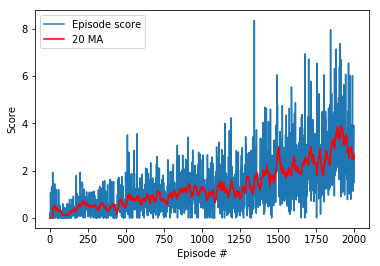

In [13]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma = 20
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

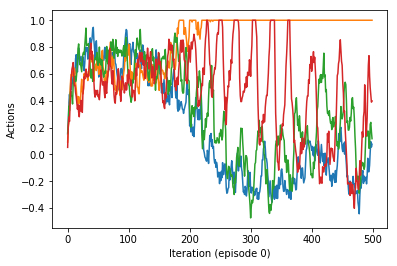

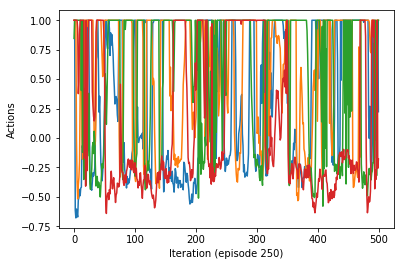

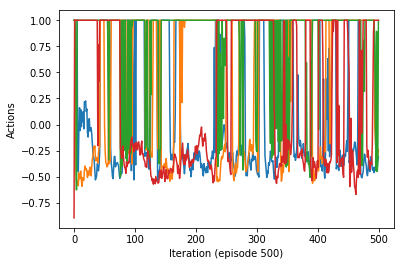

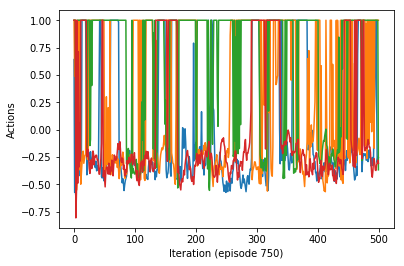

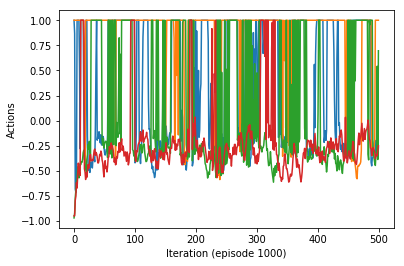

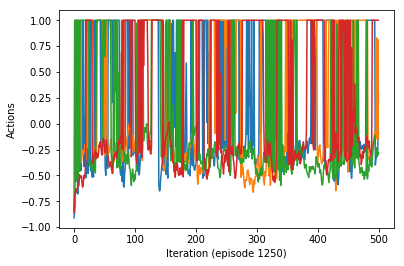

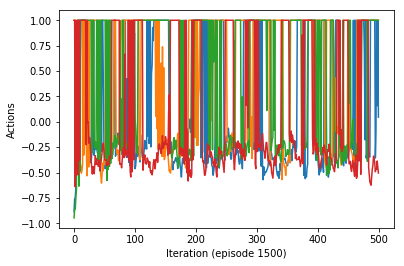

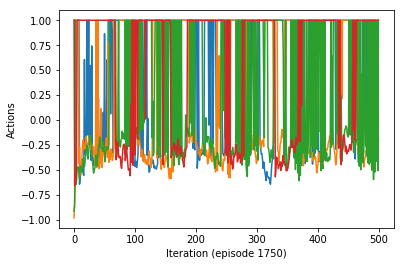

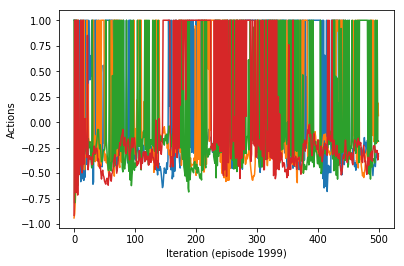

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [15]:
scores = ddpg(agent, env, 30, 2000, 500)

Episode 1	Score: 3.48	Average Score: 3.48	Actions: [-0.51799256 -0.38482028 -0.33795688  1.        ]
Episode 2	Score: 2.35	Average Score: 2.91	Actions: [ 1.         -0.23991905  1.         -0.41493952]
Episode 3	Score: 2.05	Average Score: 2.63	Actions: [-0.36384037 -0.21025456 -0.17976648  1.        ]
Episode 4	Score: 6.32	Average Score: 3.55	Actions: [ 1.         -0.31273246  1.          1.        ]
Episode 5	Score: 5.46	Average Score: 3.93	Actions: [ 1.          1.         -0.38639414  0.1536119 ]
Episode 6	Score: 2.12	Average Score: 3.63	Actions: [-0.21104106 -0.3273666  -0.20621474  1.        ]
Episode 7	Score: 2.07	Average Score: 3.41	Actions: [-0.2671342  0.3335854 -0.3241661  1.       ]
Episode 8	Score: 1.86	Average Score: 3.21	Actions: [-0.23864236 -0.28711748  1.          1.        ]
Episode 9	Score: 5.41	Average Score: 3.46	Actions: [ 1.         -0.28202718 -0.2940185  -0.30154094]
Episode 10	Score: 2.63	Average Score: 3.37	Actions: [ 1.         -0.3022417  -0.3409122  -0.421

Episode 83	Score: 0.66	Average Score: 3.08	Actions: [1. 1. 1. 1.]
Episode 84	Score: 1.99	Average Score: 3.07	Actions: [1. 1. 1. 1.]
Episode 85	Score: 7.55	Average Score: 3.12	Actions: [ 1.          1.         -0.35472083  1.        ]
Episode 86	Score: 3.75	Average Score: 3.13	Actions: [-0.36918944  0.95415306 -0.2040386  -0.53392553]
Episode 87	Score: 0.38	Average Score: 3.10	Actions: [ 1.         1.         1.        -0.3284439]
Episode 88	Score: 2.20	Average Score: 3.09	Actions: [-0.16709985 -0.39990956 -0.33952856 -0.14003488]
Episode 89	Score: 4.77	Average Score: 3.11	Actions: [ 1.         -0.42535713  0.4366025  -0.3148691 ]
Episode 90	Score: 2.58	Average Score: 3.10	Actions: [-0.19227959  1.         -0.15748651  1.        ]
Episode 91	Score: 3.41	Average Score: 3.11	Actions: [ 1.          1.         -0.279515   -0.28748417]
Episode 92	Score: 2.67	Average Score: 3.10	Actions: [ 1.         -0.42060092  1.          1.        ]
Episode 93	Score: 2.57	Average Score: 3.09	Actions: [ 1.

Episode 165	Score: 3.93	Average Score: 3.01	Actions: [-0.063139   -0.18722647 -0.4304373  -0.4605333 ]
Episode 166	Score: 0.42	Average Score: 2.98	Actions: [-0.09799324 -0.24037813 -0.31128186 -0.0840872 ]
Episode 167	Score: 1.50	Average Score: 2.97	Actions: [ 1.         1.        -0.3970147  1.       ]
Episode 168	Score: 3.23	Average Score: 2.95	Actions: [-0.38947043 -0.31949988 -0.43944544  1.        ]
Episode 169	Score: 0.67	Average Score: 2.91	Actions: [ 1.          0.28461456  1.         -0.34800467]
Episode 170	Score: 3.20	Average Score: 2.92	Actions: [ 1.          0.5159398   1.         -0.23558877]
Episode 171	Score: 2.56	Average Score: 2.90	Actions: [-0.38523477  1.          0.6223249  -0.31879264]
Episode 172	Score: 2.10	Average Score: 2.88	Actions: [-0.29141098 -0.24461946 -0.2666046   1.        ]
Episode 173	Score: 5.75	Average Score: 2.91	Actions: [ 1.          1.         -0.15222496 -0.26291496]
Episode 174	Score: 3.33	Average Score: 2.89	Actions: [-0.22458106 -0.389019  

Episode 245	Score: 2.97	Average Score: 2.97	Actions: [ 1.        -0.2040405  1.        -0.2600418]
Episode 246	Score: 0.43	Average Score: 2.94	Actions: [-0.21705106 -0.30102775 -0.21556458  1.        ]
Episode 247	Score: 2.17	Average Score: 2.92	Actions: [-0.32919735 -0.18198347 -0.5030113  -0.2613541 ]
Episode 248	Score: 1.59	Average Score: 2.91	Actions: [-0.25184733  1.          1.         -0.286975  ]
Episode 249	Score: 1.27	Average Score: 2.90	Actions: [ 1.         -0.29498425 -0.23189017 -0.27702594]
Episode 250	Score: 1.26	Average Score: 2.88	Actions: [-0.46520182  1.          1.         -0.27814847]
Episode 251	Score: 5.78	Average Score: 2.90	Actions: [-0.37775305  1.         -0.29784906 -0.40726244]
Episode 252	Score: 2.56	Average Score: 2.90	Actions: [-0.3570291   0.04086307 -0.3054608   1.        ]
Episode 253	Score: 2.85	Average Score: 2.86	Actions: [ 1.          1.          1.         -0.41507578]
Episode 254	Score: 4.60	Average Score: 2.85	Actions: [ 1.         1.        -

Episode 326	Score: 2.64	Average Score: 2.64	Actions: [-0.20238236 -0.34919748 -0.40429202 -0.34783405]
Episode 327	Score: 2.28	Average Score: 2.60	Actions: [-0.31399128 -0.16346757 -0.2944008  -0.25594416]
Episode 328	Score: 2.10	Average Score: 2.59	Actions: [-0.28075552 -0.58935434 -0.24288824  1.        ]
Episode 329	Score: 2.05	Average Score: 2.58	Actions: [-0.5000105   1.         -0.31051025 -0.35304323]
Episode 330	Score: 3.17	Average Score: 2.59	Actions: [-0.15293603  1.          1.         -0.24588081]
Episode 331	Score: 2.20	Average Score: 2.57	Actions: [ 1.         -0.54555106  1.         -0.34683475]
Episode 332	Score: 2.77	Average Score: 2.54	Actions: [-0.42195842 -0.35856348 -0.34440485 -0.20730263]
Episode 333	Score: 5.46	Average Score: 2.57	Actions: [ 1.          1.          0.9140225  -0.24478494]
Episode 334	Score: 4.17	Average Score: 2.58	Actions: [-0.35906333  1.          1.         -0.5223217 ]
Episode 335	Score: 3.73	Average Score: 2.61	Actions: [ 1.         -0.4118

Episode 406	Score: 4.67	Average Score: 3.08	Actions: [ 1.          1.         -0.23816162 -0.26652774]
Episode 407	Score: 0.15	Average Score: 3.04	Actions: [-0.30022827  1.          1.         -0.3100677 ]
Episode 408	Score: 3.34	Average Score: 3.05	Actions: [-0.39532804  1.         -0.39901802  1.        ]
Episode 409	Score: 1.05	Average Score: 3.05	Actions: [ 1.         -0.41049057  0.9259276  -0.30660054]
Episode 410	Score: 1.84	Average Score: 3.05	Actions: [-0.27502286 -0.47291997  1.         -0.36902428]
Episode 411	Score: 1.97	Average Score: 3.00	Actions: [-0.3153649   0.09215131 -0.34129676  1.        ]
Episode 412	Score: 5.88	Average Score: 3.03	Actions: [ 1.         -0.30488393 -0.37307924 -0.4998395 ]
Episode 413	Score: 3.96	Average Score: 3.04	Actions: [ 1.          1.         -0.32924598 -0.05621311]
Episode 414	Score: 5.78	Average Score: 3.05	Actions: [-0.3142692 -0.2344972 -0.3907448  1.       ]
Episode 415	Score: 1.98	Average Score: 3.06	Actions: [ 1.         -0.50104076

Episode 489	Score: 1.08	Average Score: 3.02	Actions: [ 1.         -0.02067408 -0.22507946 -0.4252168 ]
Episode 490	Score: 6.06	Average Score: 2.97	Actions: [-0.25063607  1.          1.          1.        ]
Episode 491	Score: 1.92	Average Score: 2.97	Actions: [-0.29934022 -0.41632682 -0.2991669  -0.1252931 ]
Episode 492	Score: 3.09	Average Score: 2.96	Actions: [-0.4619487   0.7796467  -0.22228546  0.9716881 ]
Episode 493	Score: 3.11	Average Score: 2.94	Actions: [ 1.          1.         -0.20270772 -0.43318546]
Episode 494	Score: 3.89	Average Score: 2.97	Actions: [-0.2156697  -0.3518065  -0.16376586 -0.15324458]
Episode 495	Score: 2.39	Average Score: 2.97	Actions: [ 1.         -0.270951    1.         -0.23406139]
Episode 496	Score: 4.34	Average Score: 2.99	Actions: [ 0.60618436 -0.16281892 -0.34658983 -0.24474953]
Episode 497	Score: 2.89	Average Score: 2.99	Actions: [ 1.         -0.34689352  1.         -0.29893225]
Episode 498	Score: 2.52	Average Score: 3.01	Actions: [-0.32028213  1.    

Episode 570	Score: 3.38	Average Score: 2.70	Actions: [-0.41847524 -0.3912306  -0.34485933 -0.39350557]
Episode 571	Score: 0.53	Average Score: 2.67	Actions: [ 1.         -0.293746   -0.28276074 -0.36130303]
Episode 572	Score: 1.08	Average Score: 2.65	Actions: [-0.5196148   1.         -0.36128882  1.        ]
Episode 573	Score: 2.51	Average Score: 2.65	Actions: [-0.19456947 -0.24030946  1.         -0.36948258]
Episode 574	Score: 1.23	Average Score: 2.60	Actions: [-0.47172934 -0.3321289  -0.27947682 -0.31191748]
Episode 575	Score: 1.86	Average Score: 2.61	Actions: [-0.43205133  0.8167489   1.          1.        ]
Episode 576	Score: 0.59	Average Score: 2.59	Actions: [ 0.9059556  -0.3628286  -0.19089828 -0.19195615]
Episode 577	Score: 3.91	Average Score: 2.61	Actions: [ 1.         -0.28659827 -0.42862353 -0.39677292]
Episode 578	Score: 2.71	Average Score: 2.61	Actions: [-0.08102327  1.          1.         -0.35625958]
Episode 579	Score: 2.01	Average Score: 2.62	Actions: [ 1.         -0.3800

Episode 650	Score: 1.93	Average Score: 2.52	Actions: [ 1.         -0.3921848   0.73175704 -0.4784807 ]
Episode 651	Score: 2.87	Average Score: 2.54	Actions: [ 1.          1.         -0.41554475  1.        ]
Episode 652	Score: 0.85	Average Score: 2.52	Actions: [ 1.         -0.35629436 -0.4556792  -0.35671154]
Episode 653	Score: 1.81	Average Score: 2.51	Actions: [ 1.          1.         -0.34016612 -0.221387  ]
Episode 654	Score: 2.42	Average Score: 2.46	Actions: [ 1.          1.         -0.25314724 -0.17720932]
Episode 655	Score: 3.65	Average Score: 2.46	Actions: [ 1.         -0.31532654 -0.32665497 -0.31482017]
Episode 656	Score: 4.69	Average Score: 2.47	Actions: [-0.32469088 -0.31116268  1.         -0.4442194 ]
Episode 657	Score: 4.60	Average Score: 2.48	Actions: [-0.3742868  -0.14948915 -0.3071401   1.        ]
Episode 658	Score: 0.54	Average Score: 2.47	Actions: [-0.17334887  1.         -0.35783035 -0.267874  ]
Episode 659	Score: 1.28	Average Score: 2.45	Actions: [-0.3703973   1.    

Episode 732	Score: 2.42	Average Score: 2.90	Actions: [-0.04592002  1.         -0.29213572 -0.24901816]
Episode 733	Score: 0.86	Average Score: 2.87	Actions: [ 1.         -0.17137767 -0.33025017 -0.17782591]
Episode 734	Score: 2.94	Average Score: 2.88	Actions: [-0.40496436 -0.21360725 -0.31595257 -0.56891567]
Episode 735	Score: 2.19	Average Score: 2.86	Actions: [-0.31260893  1.         -0.2920974  -0.1226139 ]
Episode 736	Score: 2.77	Average Score: 2.86	Actions: [ 1.         -0.24628885 -0.16847977 -0.3596632 ]
Episode 737	Score: 4.21	Average Score: 2.88	Actions: [-0.29356387 -0.36744937  1.         -0.6183537 ]
Episode 738	Score: 2.77	Average Score: 2.87	Actions: [ 1.          1.          1.         -0.37118486]
Episode 739	Score: 5.06	Average Score: 2.90	Actions: [ 0.636192    0.6163607  -0.27871114  1.        ]
Episode 740	Score: 4.61	Average Score: 2.94	Actions: [-0.3439519  -0.3038864  -0.39969963 -0.2962495 ]
Episode 741	Score: 3.35	Average Score: 2.97	Actions: [1. 1. 1. 1.]
Episod

Episode 813	Score: 4.16	Average Score: 3.70	Actions: [ 1.          1.         -0.12963113  1.        ]
Episode 814	Score: 2.36	Average Score: 3.70	Actions: [-0.15251945  1.         -0.37554085 -0.31055048]
Episode 815	Score: 2.95	Average Score: 3.72	Actions: [ 1.         -0.21482472 -0.35644427 -0.26347378]
Episode 816	Score: 5.94	Average Score: 3.76	Actions: [ 1.         -0.39041033 -0.31315416 -0.35197186]
Episode 817	Score: 5.07	Average Score: 3.77	Actions: [-0.4313205   1.         -0.19628495  1.        ]
Episode 818	Score: 7.10	Average Score: 3.81	Actions: [-0.47153738 -0.295355    1.         -0.37800688]
Episode 819	Score: 6.05	Average Score: 3.85	Actions: [ 1.         -0.17091317 -0.34388623 -0.41073838]
Episode 820	Score: 6.86	Average Score: 3.90	Actions: [ 1.         -0.17927282 -0.54989433 -0.25094357]
Episode 821	Score: 4.78	Average Score: 3.91	Actions: [ 1.         -0.01046573 -0.30576423 -0.33410874]
Episode 822	Score: 4.08	Average Score: 3.90	Actions: [ 1.          1.    

Episode 893	Score: 2.75	Average Score: 4.25	Actions: [ 1.         -0.29684243 -0.06569459 -0.17643403]
Episode 894	Score: 5.17	Average Score: 4.24	Actions: [ 1.          1.         -0.30129468 -0.44102278]
Episode 895	Score: 6.31	Average Score: 4.27	Actions: [ 1.         -0.4431544   1.         -0.53619725]
Episode 896	Score: 2.23	Average Score: 4.26	Actions: [ 0.41324395  1.         -0.45537254 -0.39833894]
Episode 897	Score: 2.32	Average Score: 4.25	Actions: [ 1.          1.         -0.3988379  -0.32360652]
Episode 898	Score: 3.01	Average Score: 4.26	Actions: [-0.08607342 -0.27429032 -0.3735814  -0.19636762]
Episode 899	Score: 2.05	Average Score: 4.22	Actions: [-0.17998497 -0.29728624 -0.43790337 -0.15568827]
Episode 900	Score: 2.44	Average Score: 4.22	Actions: [ 1.         -0.3893873   1.         -0.22548036]
Episode 900	Average Score: 4.22
Episode 901	Score: 2.17	Average Score: 4.21	Actions: [-0.5119638  -0.4235463   1.         -0.37506595]
Episode 902	Score: 3.95	Average Score: 4.

Episode 974	Score: 6.94	Average Score: 3.67	Actions: [ 1.         -0.43190494 -0.2764056   1.        ]
Episode 975	Score: 1.39	Average Score: 3.65	Actions: [-0.13090436  1.          1.          1.        ]
Episode 976	Score: 5.57	Average Score: 3.67	Actions: [-0.46478447 -0.34506986 -0.320847    1.        ]
Episode 977	Score: 3.90	Average Score: 3.65	Actions: [-0.37888682 -0.333446    1.         -0.29304397]
Episode 978	Score: 1.61	Average Score: 3.63	Actions: [-0.3365355   1.         -0.27111349  1.        ]
Episode 979	Score: 3.77	Average Score: 3.63	Actions: [-0.28773952 -0.34173885 -0.38271472 -0.20548528]
Episode 980	Score: 3.63	Average Score: 3.61	Actions: [-0.30915588 -0.39032435 -0.2146601  -0.44164532]
Episode 981	Score: 2.69	Average Score: 3.60	Actions: [ 1.          1.         -0.41586384 -0.3062901 ]
Episode 982	Score: 2.77	Average Score: 3.60	Actions: [-0.2558165  -0.4787886  -0.42008862 -0.24868293]
Episode 983	Score: 3.61	Average Score: 3.59	Actions: [-0.44989145 -0.4791

Episode 1054	Score: 4.40	Average Score: 4.28	Actions: [-0.28055716 -0.06453122  0.68123734 -0.18214533]
Episode 1055	Score: 1.77	Average Score: 4.27	Actions: [ 0.00699313 -0.4780846   1.         -0.03353535]
Episode 1056	Score: 5.49	Average Score: 4.32	Actions: [ 1.          1.         -0.33846223 -0.17631818]
Episode 1057	Score: 4.60	Average Score: 4.34	Actions: [ 1.          0.04029955 -0.3796326   1.        ]
Episode 1058	Score: 5.19	Average Score: 4.35	Actions: [-0.2495252  -0.31609932 -0.26458076 -0.24713674]
Episode 1059	Score: 2.84	Average Score: 4.31	Actions: [ 1.         1.         1.        -0.5735368]
Episode 1060	Score: 1.05	Average Score: 4.27	Actions: [ 1.          1.         -0.32993674 -0.56424654]
Episode 1061	Score: 5.74	Average Score: 4.28	Actions: [-0.38945562  1.         -0.3655629   1.        ]
Episode 1062	Score: 3.40	Average Score: 4.26	Actions: [ 1.          0.8603144  -0.38362494 -0.37050986]
Episode 1063	Score: 5.41	Average Score: 4.26	Actions: [ 1.         -

Episode 1134	Score: 6.60	Average Score: 5.32	Actions: [-0.4556041  1.         1.        -0.3453587]
Episode 1135	Score: 13.66	Average Score: 5.43	Actions: [ 1.          1.         -0.4030199  -0.36769372]
Episode 1136	Score: 7.82	Average Score: 5.47	Actions: [-0.28408578 -0.23170038 -0.46768424 -0.19813642]
Episode 1137	Score: 5.81	Average Score: 5.50	Actions: [-0.45342782 -0.27463305 -0.4512321  -0.34355718]
Episode 1138	Score: 16.60	Average Score: 5.64	Actions: [ 1.          1.         -0.38007262 -0.4934136 ]
Episode 1139	Score: 4.31	Average Score: 5.63	Actions: [ 0.01421154 -0.35509977  1.          1.        ]
Episode 1140	Score: 5.37	Average Score: 5.66	Actions: [ 1.         -0.28891018  1.         -0.3813051 ]
Episode 1141	Score: 8.37	Average Score: 5.72	Actions: [-0.37625945  1.         -0.2460254   0.5111047 ]
Episode 1142	Score: 3.61	Average Score: 5.72	Actions: [-0.31356698  1.         -0.16972068  1.        ]
Episode 1143	Score: 4.32	Average Score: 5.74	Actions: [ 1.        

Episode 1213	Score: 7.51	Average Score: 5.78	Actions: [-0.18884613 -0.12057333  1.         -0.22484952]
Episode 1214	Score: 7.04	Average Score: 5.82	Actions: [ 1.          1.         -0.2693819  -0.33646104]
Episode 1215	Score: 7.83	Average Score: 5.87	Actions: [ 1.          0.02930105  1.         -0.15344073]
Episode 1216	Score: 6.88	Average Score: 5.91	Actions: [ 1.          1.         -0.14391708 -0.24974036]
Episode 1217	Score: 4.58	Average Score: 5.92	Actions: [ 1.         1.        -0.3316405 -0.3014496]
Episode 1218	Score: 4.80	Average Score: 5.94	Actions: [ 1.          1.          1.         -0.17376983]
Episode 1219	Score: 6.91	Average Score: 5.97	Actions: [-0.24605109  1.         -0.31917772 -0.29028118]
Episode 1220	Score: 4.23	Average Score: 5.93	Actions: [-0.17334698 -0.46595436 -0.40678623 -0.58068883]
Episode 1221	Score: 5.99	Average Score: 5.95	Actions: [-0.3927767  -0.10253905 -0.12040854 -0.19791476]
Episode 1222	Score: 2.98	Average Score: 5.93	Actions: [-0.32854256 -

Episode 1294	Score: 7.77	Average Score: 5.27	Actions: [ 1.          1.         -0.23331709 -0.2042269 ]
Episode 1295	Score: 4.90	Average Score: 5.26	Actions: [-0.23432179  0.26417404 -0.42104048 -0.01530125]
Episode 1296	Score: 8.23	Average Score: 5.29	Actions: [-0.5248807  -0.28993967  1.         -0.42342344]
Episode 1297	Score: 8.32	Average Score: 5.33	Actions: [ 1.         -0.14549    -0.28057778  1.        ]
Episode 1298	Score: 2.46	Average Score: 5.29	Actions: [ 1.          1.         -0.12840821  1.        ]
Episode 1299	Score: 2.78	Average Score: 5.25	Actions: [-0.3086836  -0.27881816 -0.44953153  1.        ]
Episode 1300	Score: 3.15	Average Score: 5.25	Actions: [ 1.         -0.36539736 -0.23650098 -0.51116085]
Episode 1300	Average Score: 5.25
Episode 1301	Score: 2.55	Average Score: 5.23	Actions: [-0.25385097 -0.1924991  -0.29819587 -0.6531801 ]
Episode 1302	Score: 1.90	Average Score: 5.20	Actions: [-0.30883464  1.         -0.15941165  1.        ]
Episode 1303	Score: 2.38	Averag

Episode 1374	Score: 2.14	Average Score: 5.03	Actions: [-0.25653604  1.         -0.20788148  1.        ]
Episode 1375	Score: 5.82	Average Score: 5.03	Actions: [ 1.          0.07318787  1.         -0.20024736]
Episode 1376	Score: 7.09	Average Score: 5.09	Actions: [-0.4425801   1.         -0.19159156 -0.4362873 ]
Episode 1377	Score: 4.96	Average Score: 5.14	Actions: [ 1.         -0.4775932   1.         -0.52253246]
Episode 1378	Score: 5.62	Average Score: 5.13	Actions: [ 1.         -0.41236827 -0.35525733 -0.3372516 ]
Episode 1379	Score: 1.09	Average Score: 5.07	Actions: [-0.2023086  -0.23222339 -0.29242048  1.        ]
Episode 1380	Score: 2.75	Average Score: 5.09	Actions: [-0.29144946 -0.3108584  -0.37476626  1.        ]
Episode 1381	Score: 5.22	Average Score: 5.08	Actions: [-0.26270127 -0.286411   -0.21412064  1.        ]
Episode 1382	Score: 3.49	Average Score: 5.04	Actions: [-0.1692565  -0.26237127 -0.6546679   1.        ]
Episode 1383	Score: 4.09	Average Score: 4.98	Actions: [ 1.      

Episode 1453	Score: 5.21	Average Score: 3.77	Actions: [ 1.          1.          1.         -0.17930654]
Episode 1454	Score: 5.06	Average Score: 3.79	Actions: [-0.37564367 -0.3593358  -0.07783168 -0.32415056]
Episode 1455	Score: 4.37	Average Score: 3.80	Actions: [ 1.         -0.38081428  1.          1.        ]
Episode 1456	Score: 5.13	Average Score: 3.80	Actions: [-0.15998618 -0.2120322   1.         -0.25255108]
Episode 1457	Score: 2.78	Average Score: 3.79	Actions: [ 1.         -0.42304116 -0.28837627 -0.31454262]
Episode 1458	Score: 4.85	Average Score: 3.80	Actions: [-0.46001345  0.6058616  -0.29473245 -0.46612355]
Episode 1459	Score: 3.16	Average Score: 3.75	Actions: [ 1.         -0.35834563  1.         -0.44356504]
Episode 1460	Score: 2.59	Average Score: 3.70	Actions: [ 1.         -0.18404022  1.          1.        ]
Episode 1461	Score: 6.58	Average Score: 3.73	Actions: [-0.37515163 -0.20108944 -0.15679543 -0.58071196]
Episode 1462	Score: 2.88	Average Score: 3.71	Actions: [-0.146029

Episode 1532	Score: 3.64	Average Score: 3.95	Actions: [-0.306862   -0.37148815 -0.44943962 -0.38555422]
Episode 1533	Score: 1.70	Average Score: 3.93	Actions: [ 1.          1.          1.         -0.39883274]
Episode 1534	Score: 1.91	Average Score: 3.89	Actions: [ 1.          1.         -0.545929   -0.35273615]
Episode 1535	Score: 2.36	Average Score: 3.88	Actions: [ 1.         -0.23959333  1.         -0.34308672]
Episode 1536	Score: 4.67	Average Score: 3.89	Actions: [-0.39514527  1.          1.          1.        ]
Episode 1537	Score: 3.84	Average Score: 3.90	Actions: [-0.349578    1.         -0.31607503 -0.04973434]
Episode 1538	Score: 4.31	Average Score: 3.93	Actions: [ 0.6976802  1.        -0.1515789  0.9826235]
Episode 1539	Score: 4.29	Average Score: 3.96	Actions: [ 1.         -0.55354625 -0.3607137  -0.30718857]
Episode 1540	Score: 3.40	Average Score: 3.99	Actions: [ 1.         -0.4093292  -0.19355823 -0.1845603 ]
Episode 1541	Score: 7.81	Average Score: 4.05	Actions: [ 1.          

Episode 1611	Score: 4.60	Average Score: 4.28	Actions: [-0.15609944 -0.20197597 -0.4111951   1.        ]
Episode 1612	Score: 8.05	Average Score: 4.29	Actions: [-0.39900115 -0.33973056  1.          1.        ]
Episode 1613	Score: 6.75	Average Score: 4.33	Actions: [-0.38009307 -0.12627688 -0.6009917   0.53663504]
Episode 1614	Score: 0.96	Average Score: 4.32	Actions: [ 1.          1.         -0.33269256 -0.44567913]
Episode 1615	Score: 4.70	Average Score: 4.33	Actions: [ 1.          1.         -0.39128822 -0.1556126 ]
Episode 1616	Score: 2.05	Average Score: 4.34	Actions: [-0.40302032  1.          1.          1.        ]
Episode 1617	Score: 6.53	Average Score: 4.37	Actions: [ 1.         -0.2916747  -0.38621852 -0.36833772]
Episode 1618	Score: 3.02	Average Score: 4.36	Actions: [ 1.          1.         -0.26522416  1.        ]
Episode 1619	Score: 8.29	Average Score: 4.41	Actions: [ 1.          0.47637194 -0.32916677  1.        ]
Episode 1620	Score: 1.86	Average Score: 4.39	Actions: [ 1.      

Episode 1690	Score: 3.72	Average Score: 4.06	Actions: [ 1.         -0.3803077   0.22575152  1.        ]
Episode 1691	Score: 7.19	Average Score: 4.03	Actions: [ 1.          0.4342831  -0.31962666 -0.5038111 ]
Episode 1692	Score: 4.55	Average Score: 4.05	Actions: [-0.36501914 -0.3550899  -0.4087696  -0.3501807 ]
Episode 1693	Score: 1.58	Average Score: 4.01	Actions: [ 1.         -0.37056047  1.         -0.28499314]
Episode 1694	Score: 2.87	Average Score: 4.04	Actions: [-0.41738096  1.         -0.40054667 -0.3708593 ]
Episode 1695	Score: 1.88	Average Score: 4.03	Actions: [-0.4817279   1.         -0.43889558  1.        ]
Episode 1696	Score: 5.93	Average Score: 4.06	Actions: [-0.4114929   1.          1.         -0.12049225]
Episode 1697	Score: 1.95	Average Score: 4.07	Actions: [-0.3246705  -0.26606357 -0.48930788  1.        ]
Episode 1698	Score: 4.05	Average Score: 4.10	Actions: [-0.39257607 -0.28894562 -0.19036703 -0.4239084 ]
Episode 1699	Score: 3.59	Average Score: 4.10	Actions: [-0.458295

Episode 1769	Score: 2.94	Average Score: 4.17	Actions: [-0.38508266 -0.36152634 -0.37591216 -0.3359845 ]
Episode 1770	Score: 4.18	Average Score: 4.16	Actions: [-0.13352796 -0.46290392 -0.15346096  1.        ]
Episode 1771	Score: 1.97	Average Score: 4.13	Actions: [ 1.          1.          1.         -0.22032665]
Episode 1772	Score: 3.63	Average Score: 4.12	Actions: [ 1.         -0.3587347  -0.26530364 -0.20121853]
Episode 1773	Score: 4.72	Average Score: 4.13	Actions: [-0.21612903 -0.27712148 -0.0291919  -0.5017677 ]
Episode 1774	Score: 4.43	Average Score: 4.12	Actions: [-0.26137123 -0.367899   -0.39966482 -0.07681361]
Episode 1775	Score: 5.74	Average Score: 4.13	Actions: [ 1.         -0.33622095  0.73777795 -0.24614224]
Episode 1776	Score: 3.77	Average Score: 4.09	Actions: [ 1.         -0.36700892 -0.38971534 -0.26597697]
Episode 1777	Score: 0.91	Average Score: 4.08	Actions: [ 1.          1.         -0.3927669  -0.20666793]
Episode 1778	Score: 6.72	Average Score: 4.10	Actions: [-0.319336

Episode 1848	Score: 12.25	Average Score: 4.27	Actions: [ 1.         -0.3475301   1.         -0.37703153]
Episode 1849	Score: 3.87	Average Score: 4.23	Actions: [1.        1.        0.8744691 1.       ]
Episode 1850	Score: 2.74	Average Score: 4.24	Actions: [-0.42611772 -0.15125178 -0.38340804 -0.44097623]
Episode 1851	Score: 6.01	Average Score: 4.30	Actions: [-0.21102266 -0.30710125 -0.46976912 -0.11815917]
Episode 1852	Score: 9.64	Average Score: 4.36	Actions: [-0.35517696  1.         -0.11395181 -0.34356377]
Episode 1853	Score: 1.38	Average Score: 4.34	Actions: [ 1.          1.         -0.30192736  1.        ]
Episode 1854	Score: 4.43	Average Score: 4.31	Actions: [-0.39338952  0.02628098 -0.21596329 -0.38685867]
Episode 1855	Score: 2.48	Average Score: 4.31	Actions: [-0.46008915 -0.39682156 -0.27069896  1.        ]
Episode 1856	Score: 4.42	Average Score: 4.22	Actions: [ 1.          1.          0.40184954 -0.3570347 ]
Episode 1857	Score: 1.22	Average Score: 4.18	Actions: [-0.1942113   1. 

Episode 1927	Score: 7.68	Average Score: 3.64	Actions: [-0.4370642  -0.31213623 -0.4919914   1.        ]
Episode 1928	Score: 5.00	Average Score: 3.66	Actions: [-0.28990602 -0.21394692  1.         -0.31266403]
Episode 1929	Score: 4.70	Average Score: 3.69	Actions: [ 1.         -0.37981594  1.         -0.35979474]
Episode 1930	Score: 2.88	Average Score: 3.65	Actions: [ 1.         -0.3686693   1.         -0.25106597]
Episode 1931	Score: 2.84	Average Score: 3.67	Actions: [ 1.         -0.23607214 -0.46250483 -0.31572536]
Episode 1932	Score: 4.52	Average Score: 3.65	Actions: [-0.41435677 -0.15631005 -0.2981153  -0.3449703 ]
Episode 1933	Score: 1.47	Average Score: 3.62	Actions: [ 1.          1.          1.         -0.23882465]
Episode 1934	Score: 4.77	Average Score: 3.61	Actions: [-0.4250098  -0.27303416 -0.49258634  1.        ]
Episode 1935	Score: 1.12	Average Score: 3.62	Actions: [-0.3769111  -0.2676977  -0.20144852 -0.3430679 ]
Episode 1936	Score: 1.51	Average Score: 3.60	Actions: [ 1.      

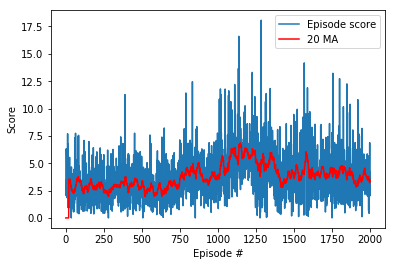

In [16]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

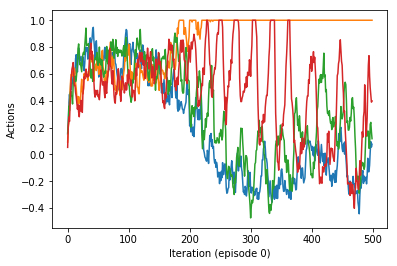

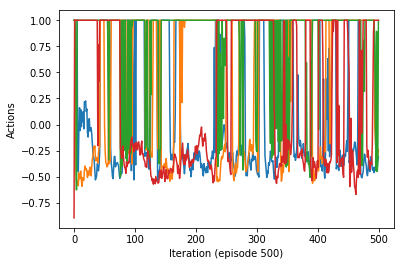

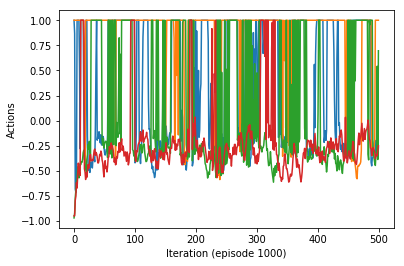

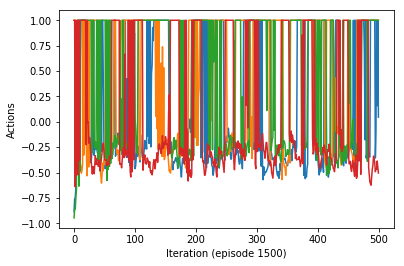

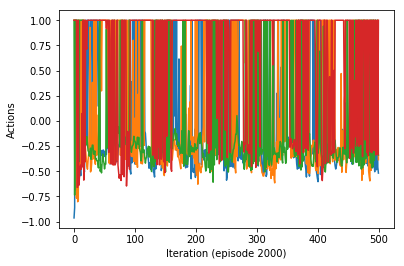

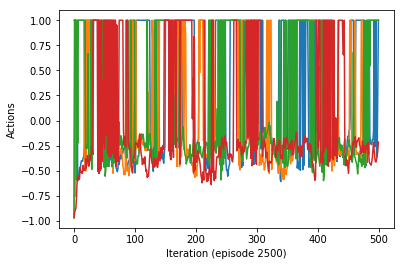

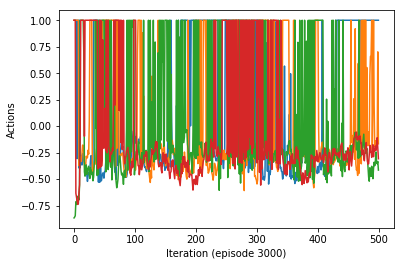

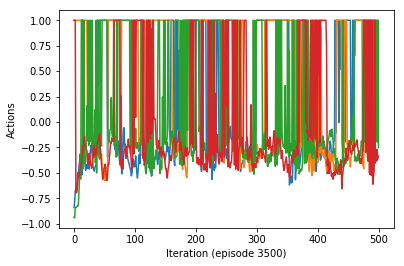

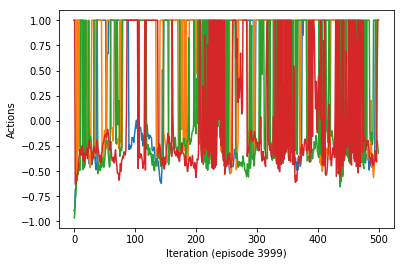

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [18]:
scores = ddpg(agent, env, 30, 1000, 500)

Episode 1	Score: 0.29	Average Score: 0.29	Actions: [-0.39269027 -0.23229666 -0.30678567 -0.511448  ]
Episode 2	Score: 1.30	Average Score: 0.79	Actions: [-0.27907762 -0.2886394  -0.53179795  1.        ]
Episode 3	Score: 3.12	Average Score: 1.57	Actions: [ 1.          1.         -0.35932958 -0.32689813]
Episode 4	Score: 2.09	Average Score: 1.70	Actions: [ 1.          1.         -0.34534597 -0.2926195 ]
Episode 5	Score: 1.74	Average Score: 1.71	Actions: [-0.30562183 -0.28038567 -0.3298738  -0.39254516]
Episode 6	Score: 1.87	Average Score: 1.73	Actions: [-0.37414187 -0.24313861  1.          1.        ]
Episode 7	Score: 2.46	Average Score: 1.84	Actions: [-0.57124096 -0.23793514 -0.42779362  1.        ]
Episode 8	Score: 4.20	Average Score: 2.13	Actions: [ 1.         -0.27788714 -0.14421068 -0.393824  ]
Episode 9	Score: 4.42	Average Score: 2.39	Actions: [-0.4416668 -0.2096761 -0.0573652  1.       ]
Episode 10	Score: 1.53	Average Score: 2.30	Actions: [-0.533289   -0.48873168 -0.23041777 -0.375

Episode 82	Score: 4.62	Average Score: 2.76	Actions: [ 1.          0.999866   -0.33039546 -0.39943758]
Episode 83	Score: 4.00	Average Score: 2.77	Actions: [-0.4509306  -0.2740183  -0.31618297 -0.09566085]
Episode 84	Score: 2.21	Average Score: 2.77	Actions: [-0.05856453 -0.5233316  -0.34756005 -0.2255503 ]
Episode 85	Score: 3.59	Average Score: 2.78	Actions: [ 1.         -0.21392499 -0.416168    1.        ]
Episode 86	Score: 2.14	Average Score: 2.77	Actions: [-0.24668089 -0.29818496 -0.13946937 -0.4137416 ]
Episode 87	Score: 3.61	Average Score: 2.78	Actions: [ 1.         -0.30623412  1.         -0.27615607]
Episode 88	Score: 1.85	Average Score: 2.77	Actions: [ 1.         -0.41554204  0.13413633  1.        ]
Episode 89	Score: 2.69	Average Score: 2.77	Actions: [ 1.         -0.38747585 -0.3664182  -0.33146843]
Episode 90	Score: 4.34	Average Score: 2.78	Actions: [-0.44456777  1.          1.         -0.30958548]
Episode 91	Score: 2.06	Average Score: 2.78	Actions: [-0.31596982  1.         -0.21

Episode 162	Score: 1.45	Average Score: 3.44	Actions: [-0.03716527 -0.35132763 -0.29132077 -0.29445988]
Episode 163	Score: 1.81	Average Score: 3.43	Actions: [ 1.         -0.25937378  1.         -0.43825132]
Episode 164	Score: 4.12	Average Score: 3.46	Actions: [ 1.         -0.11786302 -0.23947705 -0.32689914]
Episode 165	Score: 0.31	Average Score: 3.44	Actions: [ 1.         0.2880911  1.        -0.4936747]
Episode 166	Score: 1.64	Average Score: 3.45	Actions: [ 0.84759355 -0.16215992 -0.27712592  1.        ]
Episode 167	Score: 6.73	Average Score: 3.48	Actions: [ 1.          0.730402   -0.2867723  -0.47336584]
Episode 168	Score: 2.71	Average Score: 3.48	Actions: [ 1.         -0.26909903 -0.26793787 -0.18270573]
Episode 169	Score: 2.76	Average Score: 3.47	Actions: [-0.45185837  1.         -0.22573583  1.        ]
Episode 170	Score: 3.30	Average Score: 3.49	Actions: [ 1.          1.         -0.43276814 -0.42054367]
Episode 171	Score: 5.63	Average Score: 3.53	Actions: [ 0.19603688 -0.2138244 

Episode 242	Score: 4.89	Average Score: 4.41	Actions: [ 1.          0.9595011  -0.30429527 -0.19885832]
Episode 243	Score: 3.07	Average Score: 4.43	Actions: [-0.3716554   1.         -0.39910442  1.        ]
Episode 244	Score: 2.38	Average Score: 4.43	Actions: [ 1.         -0.2607365  -0.49024808 -0.32225183]
Episode 245	Score: 4.45	Average Score: 4.44	Actions: [ 0.10454547  1.         -0.38126153 -0.3388465 ]
Episode 246	Score: 5.46	Average Score: 4.45	Actions: [-0.2162517  1.        -0.4208206  1.       ]
Episode 247	Score: 4.28	Average Score: 4.42	Actions: [-0.38869408 -0.20611818 -0.3781823  -0.4717182 ]
Episode 248	Score: 1.36	Average Score: 4.39	Actions: [-0.2304042  -0.16443177 -0.49908957 -0.28855053]
Episode 249	Score: 4.82	Average Score: 4.41	Actions: [-0.34426937 -0.37171748 -0.29647604 -0.29042292]
Episode 250	Score: 1.97	Average Score: 4.40	Actions: [ 1.          1.         -0.27862665  1.        ]
Episode 251	Score: 3.80	Average Score: 4.37	Actions: [ 1.        -0.3007008  

Episode 322	Score: 9.62	Average Score: 4.01	Actions: [-0.08501158 -0.20041771 -0.27472672 -0.27856356]
Episode 323	Score: 4.21	Average Score: 4.00	Actions: [-0.30063856  1.          1.         -0.2862989 ]
Episode 324	Score: 4.33	Average Score: 3.98	Actions: [ 1.         -0.35175246 -0.41936275 -0.1390254 ]
Episode 325	Score: 6.24	Average Score: 3.99	Actions: [ 1.         -0.24943343 -0.48053753 -0.32365203]
Episode 326	Score: 2.35	Average Score: 4.00	Actions: [ 1.         -0.41108787 -0.3391455  -0.02097241]
Episode 327	Score: 1.94	Average Score: 3.96	Actions: [-0.38802233 -0.19676135  1.         -0.31802925]
Episode 328	Score: 1.67	Average Score: 3.94	Actions: [-0.36231554 -0.3412874  -0.33623755 -0.37476683]
Episode 329	Score: 2.31	Average Score: 3.94	Actions: [ 1.         -0.47392157 -0.17027408 -0.39107078]
Episode 330	Score: 5.82	Average Score: 3.95	Actions: [-0.38416433 -0.29582867 -0.12312939 -0.31257004]
Episode 331	Score: 7.58	Average Score: 3.97	Actions: [ 1.          1.    

Episode 402	Score: 5.16	Average Score: 4.09	Actions: [-0.27510795 -0.34568223 -0.18047424 -0.36676708]
Episode 403	Score: 3.32	Average Score: 4.07	Actions: [ 1.         -0.28728694 -0.33441818 -0.16403742]
Episode 404	Score: 2.13	Average Score: 4.06	Actions: [ 1.          1.         -0.2869367  -0.02271968]
Episode 405	Score: 2.73	Average Score: 4.08	Actions: [-0.3076828  -0.27963048 -0.3598442  -0.5228478 ]
Episode 406	Score: 3.32	Average Score: 4.11	Actions: [ 1.         -0.37421262 -0.1414886  -0.29251525]
Episode 407	Score: 4.06	Average Score: 4.11	Actions: [-0.49607006 -0.41583842 -0.2208335  -0.1250643 ]
Episode 408	Score: 2.28	Average Score: 4.12	Actions: [-0.4555086   1.         -0.25917086 -0.22329159]
Episode 409	Score: 2.46	Average Score: 4.11	Actions: [ 1.         -0.38517296  1.         -0.5023367 ]
Episode 410	Score: 6.24	Average Score: 4.14	Actions: [ 1.         -0.30563322 -0.26293528 -0.26737615]
Episode 411	Score: 3.96	Average Score: 4.16	Actions: [ 1.         -0.3739

Episode 482	Score: 4.23	Average Score: 4.12	Actions: [-0.27880222  1.          1.          1.        ]
Episode 483	Score: 4.88	Average Score: 4.15	Actions: [1. 1. 1. 1.]
Episode 484	Score: 6.36	Average Score: 4.20	Actions: [-0.261145   -0.4036127  -0.5020767  -0.19318235]
Episode 485	Score: 4.20	Average Score: 4.20	Actions: [ 1.         -0.37032974  1.         -0.43472984]
Episode 486	Score: 3.14	Average Score: 4.21	Actions: [-0.05507304 -0.10110649 -0.22249317 -0.29809806]
Episode 487	Score: 4.38	Average Score: 4.23	Actions: [ 1.         -0.08226993 -0.4380519  -0.33879277]
Episode 488	Score: 2.77	Average Score: 4.19	Actions: [ 1.          1.         -0.10696943  1.        ]
Episode 489	Score: 3.03	Average Score: 4.20	Actions: [ 0.31836924 -0.1164522  -0.20982261 -0.4690645 ]
Episode 490	Score: 5.55	Average Score: 4.23	Actions: [ 1.         -0.3262761  -0.38722453 -0.28174564]
Episode 491	Score: 2.37	Average Score: 4.19	Actions: [-0.46593404  1.         -0.07235435 -0.5058801 ]
Episod

Episode 562	Score: 2.41	Average Score: 4.53	Actions: [ 1.         1.        -0.3336596  1.       ]
Episode 563	Score: 6.16	Average Score: 4.53	Actions: [ 1.         -0.4259127  -0.24178548 -0.08902308]
Episode 564	Score: 3.41	Average Score: 4.54	Actions: [ 1.         -0.03170133 -0.30143255 -0.25783807]
Episode 565	Score: 3.06	Average Score: 4.52	Actions: [-0.40311092 -0.20198545 -0.25421724  0.6274273 ]
Episode 566	Score: 4.12	Average Score: 4.55	Actions: [-0.35706648 -0.29154223 -0.6156026  -0.354148  ]
Episode 567	Score: 5.95	Average Score: 4.56	Actions: [ 1.         -0.54413414  1.         -0.32440868]
Episode 568	Score: 6.14	Average Score: 4.55	Actions: [ 1.         -0.39852205  1.         -0.10878834]
Episode 569	Score: 7.39	Average Score: 4.60	Actions: [ 1.         -0.27225137 -0.55756164  1.        ]
Episode 570	Score: 4.08	Average Score: 4.56	Actions: [ 1.         -0.21543607 -0.20678861 -0.33337548]
Episode 571	Score: 5.44	Average Score: 4.58	Actions: [-0.3534732   1.        

Episode 642	Score: 6.37	Average Score: 4.73	Actions: [ 1.          1.         -0.29968092 -0.30254635]
Episode 643	Score: 7.05	Average Score: 4.75	Actions: [-0.43348807 -0.26897284 -0.29818252  1.        ]
Episode 644	Score: 1.61	Average Score: 4.75	Actions: [-0.22634472  1.          1.         -0.33467913]
Episode 645	Score: 4.45	Average Score: 4.75	Actions: [-0.31254238 -0.33255723 -0.35178322 -0.46839514]
Episode 646	Score: 3.21	Average Score: 4.73	Actions: [-0.22238562  1.         -0.37492773  1.        ]
Episode 647	Score: 4.84	Average Score: 4.72	Actions: [-0.3181335   1.         -0.28806776 -0.13473697]
Episode 648	Score: 5.00	Average Score: 4.72	Actions: [-0.40010512 -0.27482074 -0.19361813 -0.06649839]
Episode 649	Score: 7.26	Average Score: 4.77	Actions: [-0.25626364 -0.41163722  1.          0.14125949]
Episode 650	Score: 6.20	Average Score: 4.78	Actions: [ 1.         -0.48252046  1.         -0.4777183 ]
Episode 651	Score: 5.40	Average Score: 4.76	Actions: [-0.59032005  1.    

Episode 722	Score: 6.47	Average Score: 5.33	Actions: [ 1.         -0.15692186  1.         -0.36016208]
Episode 723	Score: 5.18	Average Score: 5.30	Actions: [-0.31029797  1.         -0.12296246 -0.32430393]
Episode 724	Score: 12.83	Average Score: 5.40	Actions: [ 1.          1.         -0.36205223 -0.19780634]
Episode 725	Score: 3.50	Average Score: 5.40	Actions: [-0.29550034 -0.33228898  1.         -0.1835861 ]
Episode 726	Score: 3.13	Average Score: 5.37	Actions: [ 1.         -0.3300717   1.         -0.42520195]
Episode 727	Score: 5.74	Average Score: 5.35	Actions: [-0.17762524  1.         -0.3933916  -0.04944001]
Episode 728	Score: 2.95	Average Score: 5.33	Actions: [-0.508527   -0.29360768  1.          1.        ]
Episode 729	Score: 2.82	Average Score: 5.32	Actions: [-0.39610758  1.         -0.46631882 -0.40657088]
Episode 730	Score: 2.40	Average Score: 5.29	Actions: [-0.45060495  1.         -0.3681534   1.        ]
Episode 731	Score: 6.08	Average Score: 5.28	Actions: [-0.4800716  -0.453

Episode 802	Score: 6.67	Average Score: 4.57	Actions: [-0.19143346  1.         -0.52839756 -0.38073623]
Episode 803	Score: 8.05	Average Score: 4.61	Actions: [ 1.         -0.47421825  1.         -0.01177931]
Episode 804	Score: 10.81	Average Score: 4.68	Actions: [-0.57397825 -0.2982682  -0.3707509  -0.42357904]
Episode 805	Score: 9.02	Average Score: 4.75	Actions: [-0.33270693  1.         -0.43695703 -0.38772562]
Episode 806	Score: 3.53	Average Score: 4.74	Actions: [-0.3052482  -0.2900574  -0.36427915  1.        ]
Episode 807	Score: 5.21	Average Score: 4.76	Actions: [ 1.          1.         -0.38996628 -0.45801842]
Episode 808	Score: 5.00	Average Score: 4.76	Actions: [-0.27053213 -0.45200709 -0.23257248  0.42587063]
Episode 809	Score: 4.20	Average Score: 4.75	Actions: [ 1.         -0.5333117  -0.3698172  -0.49223655]
Episode 810	Score: 6.04	Average Score: 4.76	Actions: [-0.36798182  1.          1.         -0.01740076]
Episode 811	Score: 3.75	Average Score: 4.76	Actions: [ 1.         -0.210

Episode 882	Score: 4.50	Average Score: 4.98	Actions: [ 1.          1.         -0.23567076 -0.39470604]
Episode 883	Score: 1.88	Average Score: 4.96	Actions: [ 1.         1.        -0.5386567  1.       ]
Episode 884	Score: 4.03	Average Score: 4.98	Actions: [ 0.04825272 -0.22974302  1.         -0.31875846]
Episode 885	Score: 5.28	Average Score: 4.99	Actions: [-0.30543476 -0.34204158 -0.39501217 -0.27288455]
Episode 886	Score: 4.57	Average Score: 4.93	Actions: [ 1.         -0.40281826 -0.240212   -0.15409379]
Episode 887	Score: 5.31	Average Score: 4.96	Actions: [ 1.          1.         -0.15712695 -0.4270867 ]
Episode 888	Score: 6.03	Average Score: 4.98	Actions: [-0.45487565 -0.33103213 -0.29930133 -0.35570753]
Episode 889	Score: 6.96	Average Score: 5.02	Actions: [ 0.85684687  1.         -0.572533    1.        ]
Episode 890	Score: 7.98	Average Score: 5.07	Actions: [ 1.          1.         -0.4973121  -0.29849228]
Episode 891	Score: 7.94	Average Score: 5.12	Actions: [ 1.         -0.0258137 

Episode 962	Score: 11.95	Average Score: 5.19	Actions: [ 1.        -0.3352625  1.         1.       ]
Episode 963	Score: 4.47	Average Score: 5.18	Actions: [-0.26133266 -0.4800393  -0.2913101   1.        ]
Episode 964	Score: 4.02	Average Score: 5.15	Actions: [ 1.          1.         -0.27926767 -0.38434318]
Episode 965	Score: 9.36	Average Score: 5.18	Actions: [-0.22164387  1.         -0.27272058 -0.30885395]
Episode 966	Score: 9.88	Average Score: 5.25	Actions: [ 1.          1.         -0.35267922 -0.24722232]
Episode 967	Score: 5.11	Average Score: 5.22	Actions: [ 1.         -0.4147954  -0.5150851  -0.22495945]
Episode 968	Score: 4.36	Average Score: 5.24	Actions: [ 1.         -0.3940617   1.         -0.46720514]
Episode 969	Score: 4.64	Average Score: 5.18	Actions: [ 0.8924992  -0.4131417  -0.4092908  -0.15841189]
Episode 970	Score: 2.67	Average Score: 5.18	Actions: [ 1.         -0.39122236  0.7219774  -0.3246485 ]
Episode 971	Score: 5.64	Average Score: 5.20	Actions: [-0.1991267  -0.4475478

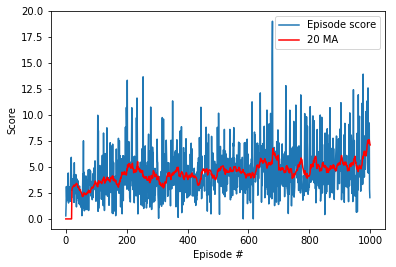

In [19]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

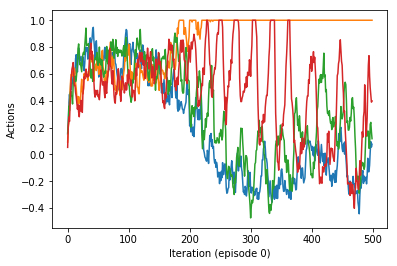

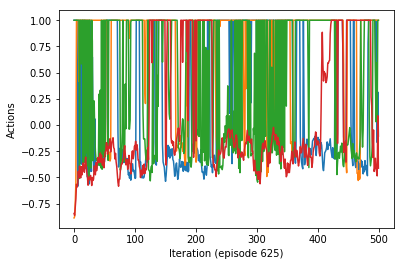

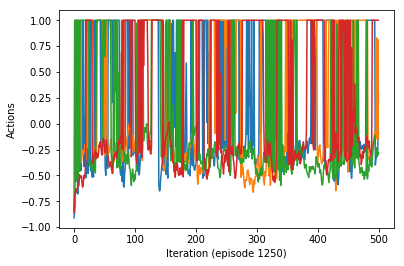

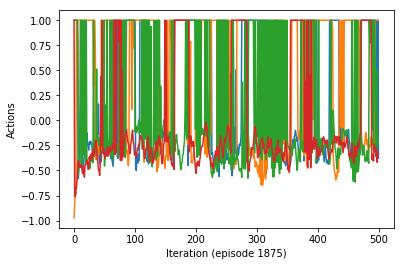

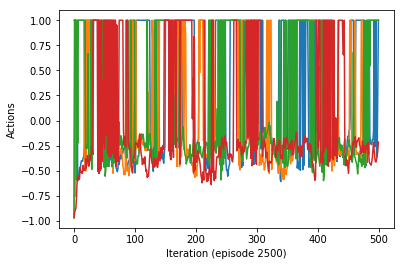

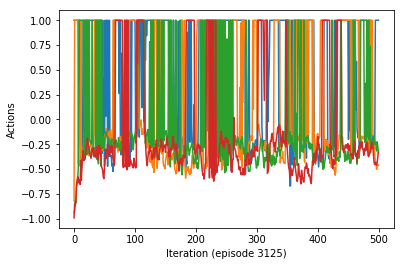

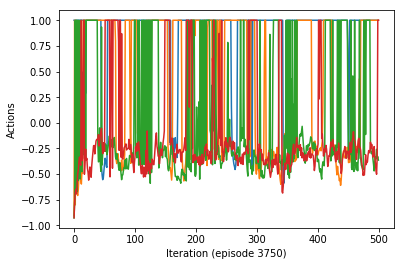

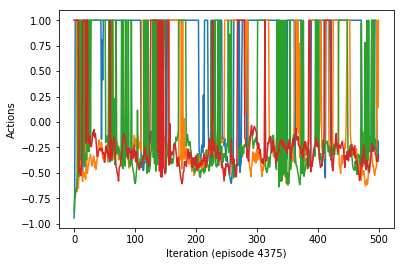

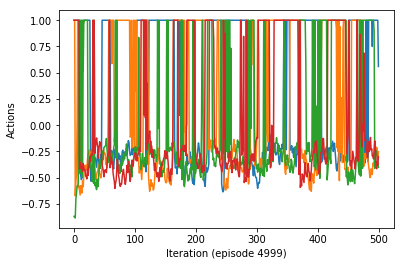

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [21]:
scores = ddpg(agent, env, 30, 1000, 500)

Episode 1	Score: 5.08	Average Score: 5.08	Actions: [-0.3266402   1.         -0.34398344 -0.30855873]
Episode 2	Score: 6.72	Average Score: 5.90	Actions: [ 1.         -0.15486845  1.          0.19882101]
Episode 3	Score: 8.54	Average Score: 6.78	Actions: [ 1.          1.         -0.29695565 -0.21842898]
Episode 4	Score: 9.24	Average Score: 7.39	Actions: [-0.41386437 -0.3735692  -0.3273627   1.        ]
Episode 5	Score: 3.49	Average Score: 6.61	Actions: [-0.5052811   1.         -0.25460383 -0.13841587]
Episode 6	Score: 5.68	Average Score: 6.46	Actions: [-0.2042541  -0.36585122 -0.31627214  0.26020908]
Episode 7	Score: 14.11	Average Score: 7.55	Actions: [-0.25176272  1.         -0.11630591  1.        ]
Episode 8	Score: 8.62	Average Score: 7.68	Actions: [ 1.         -0.32568452 -0.22193635 -0.53808534]
Episode 9	Score: 5.83	Average Score: 7.48	Actions: [ 1.         -0.20619875  1.         -0.36315143]
Episode 10	Score: 6.78	Average Score: 7.41	Actions: [ 1.       -0.307194  1.        1.    

Episode 83	Score: 7.82	Average Score: 5.92	Actions: [-0.40731016 -0.26596522  1.         -0.29907036]
Episode 84	Score: 5.29	Average Score: 5.91	Actions: [1.        0.5003629 1.        1.       ]
Episode 85	Score: 3.02	Average Score: 5.87	Actions: [-0.40323293 -0.3673667  -0.4225065   1.        ]
Episode 86	Score: 6.19	Average Score: 5.88	Actions: [-0.30810907  1.         -0.5074811   0.60131264]
Episode 87	Score: 0.90	Average Score: 5.82	Actions: [ 1.         -0.3533489   1.         -0.44433996]
Episode 88	Score: 10.27	Average Score: 5.87	Actions: [-0.2511452  1.        -0.3507378 -0.4943601]
Episode 89	Score: 0.22	Average Score: 5.81	Actions: [ 1.         1.         1.        -0.3261339]
Episode 90	Score: 3.01	Average Score: 5.78	Actions: [-0.3790193   1.         -0.23735967  1.        ]
Episode 91	Score: 5.11	Average Score: 5.77	Actions: [-0.307279   -0.56884503 -0.3837896   1.        ]
Episode 92	Score: 3.98	Average Score: 5.75	Actions: [-0.28953746  1.          1.         -0.35832

Episode 163	Score: 5.80	Average Score: 5.20	Actions: [ 1.         -0.21157916 -0.31180304  1.        ]
Episode 164	Score: 4.83	Average Score: 5.22	Actions: [ 1.         -0.35905564  1.         -0.64389783]
Episode 165	Score: 9.21	Average Score: 5.28	Actions: [-0.40948188  1.          1.         -0.3727649 ]
Episode 166	Score: 3.09	Average Score: 5.23	Actions: [ 1.          1.         -0.38050377 -0.14252053]
Episode 167	Score: 2.78	Average Score: 5.21	Actions: [-0.3786484   1.         -0.18650079 -0.23617876]
Episode 168	Score: 5.09	Average Score: 5.20	Actions: [ 1.         -0.19934912 -0.31056637 -0.29078418]
Episode 169	Score: 3.91	Average Score: 5.17	Actions: [-0.50179297 -0.4280159  -0.40059954  1.        ]
Episode 170	Score: 7.19	Average Score: 5.18	Actions: [ 1.          1.         -0.30752334 -0.3043718 ]
Episode 171	Score: 10.62	Average Score: 5.17	Actions: [-0.27500755  1.         -0.49818018 -0.35896522]
Episode 172	Score: 3.22	Average Score: 5.13	Actions: [-0.21297841 -0.068

Episode 243	Score: 5.75	Average Score: 5.43	Actions: [ 1.          1.         -0.39551255 -0.28751594]
Episode 244	Score: 2.91	Average Score: 5.36	Actions: [-0.13640176 -0.21776246 -0.09953584 -0.449501  ]
Episode 245	Score: 3.62	Average Score: 5.36	Actions: [ 1.         -0.26134896  1.          1.        ]
Episode 246	Score: 4.24	Average Score: 5.38	Actions: [ 0.21624473 -0.2599927   0.47389612 -0.42089954]
Episode 247	Score: 4.34	Average Score: 5.39	Actions: [ 1.          1.         -0.30172998 -0.5717343 ]
Episode 248	Score: 4.48	Average Score: 5.38	Actions: [-0.2053958  -0.25590485 -0.3845649   0.00197963]
Episode 249	Score: 3.99	Average Score: 5.33	Actions: [ 1.         -0.42354935 -0.31795505 -0.36365604]
Episode 250	Score: 4.36	Average Score: 5.32	Actions: [-0.43275693 -0.38738403  1.         -0.39142817]
Episode 251	Score: 0.94	Average Score: 5.25	Actions: [-0.06745085 -0.24549963 -0.29248166 -0.36576957]
Episode 252	Score: 7.11	Average Score: 5.27	Actions: [ 1.          0.8914

Episode 323	Score: 5.68	Average Score: 4.95	Actions: [-0.18027104 -0.4790766  -0.3135099  -0.13031007]
Episode 324	Score: 5.59	Average Score: 4.96	Actions: [ 1.         -0.42196342 -0.2404625  -0.29307625]
Episode 325	Score: 6.43	Average Score: 4.96	Actions: [ 1.         -0.22379714  1.          1.        ]
Episode 326	Score: 3.45	Average Score: 4.93	Actions: [ 1.         -0.49726972 -0.2502209   0.3783374 ]
Episode 327	Score: 5.86	Average Score: 4.95	Actions: [ 1.          1.         -0.43364525 -0.23660633]
Episode 328	Score: 5.68	Average Score: 4.95	Actions: [-0.3121089  -0.19996107  1.          1.        ]
Episode 329	Score: 6.99	Average Score: 4.97	Actions: [ 0.16671255  1.         -0.28330693  1.        ]
Episode 330	Score: 3.85	Average Score: 4.91	Actions: [0.5380424 1.        1.        1.       ]
Episode 331	Score: 8.39	Average Score: 4.93	Actions: [ 0.06686379  1.         -0.2986045  -0.1388074 ]
Episode 332	Score: 4.34	Average Score: 4.94	Actions: [-0.46396193 -0.3821668  -0.

Episode 402	Score: 4.15	Average Score: 5.13	Actions: [ 1.         -0.32748514 -0.34332994 -0.38837814]
Episode 403	Score: 3.45	Average Score: 5.12	Actions: [-0.39057925  1.         -0.4950793  -0.27496874]
Episode 404	Score: 5.50	Average Score: 5.12	Actions: [ 1.        -0.397253  -0.4275348  1.       ]
Episode 405	Score: 1.94	Average Score: 5.10	Actions: [-0.14286217  1.         -0.32194453 -0.16627137]
Episode 406	Score: 5.79	Average Score: 5.09	Actions: [-0.2064681  -0.27017856 -0.2399785   1.        ]
Episode 407	Score: 9.24	Average Score: 5.13	Actions: [-0.24410668 -0.44073406 -0.53428364 -0.36874583]
Episode 408	Score: 4.33	Average Score: 5.11	Actions: [ 1.        -0.2373072 -0.2594436  0.0823587]
Episode 409	Score: 2.48	Average Score: 5.10	Actions: [-0.37278435 -0.35632804 -0.37579182 -0.19050261]
Episode 410	Score: 5.01	Average Score: 5.11	Actions: [-0.31148362 -0.26490682 -0.21873721 -0.517462  ]
Episode 411	Score: 1.99	Average Score: 5.06	Actions: [ 1.         -0.45492333 -0.

Episode 482	Score: 0.45	Average Score: 4.93	Actions: [-0.18291235 -0.2618118  -0.08755837 -0.42082077]
Episode 483	Score: 3.36	Average Score: 4.94	Actions: [-0.30622497 -0.25052008  0.04519722  0.31023303]
Episode 484	Score: 7.42	Average Score: 4.98	Actions: [-0.33504227  1.         -0.15634944  1.        ]
Episode 485	Score: 3.82	Average Score: 4.91	Actions: [ 1.         1.        -0.5624369  1.       ]
Episode 486	Score: 8.06	Average Score: 4.90	Actions: [-0.41947696  1.         -0.38824245 -0.3537972 ]
Episode 487	Score: 9.28	Average Score: 4.94	Actions: [ 1.         -0.24921148 -0.32916185  0.0070163 ]
Episode 488	Score: 6.16	Average Score: 4.93	Actions: [-0.6039603   1.         -0.34728712 -0.21685913]
Episode 489	Score: 3.69	Average Score: 4.90	Actions: [ 1.         1.        -0.2788913  0.8392062]
Episode 490	Score: 4.02	Average Score: 4.90	Actions: [-0.22396304 -0.23578873  1.         -0.46451482]
Episode 491	Score: 6.40	Average Score: 4.92	Actions: [ 1.         -0.29159945 -0.

Episode 562	Score: 3.32	Average Score: 4.81	Actions: [ 1.         1.        -0.5334906  1.       ]
Episode 563	Score: 1.18	Average Score: 4.77	Actions: [-0.30130678 -0.36693197  1.          1.        ]
Episode 564	Score: 4.12	Average Score: 4.79	Actions: [ 1.         -0.25139683  1.         -0.30429363]
Episode 565	Score: 6.18	Average Score: 4.80	Actions: [-0.13753772 -0.30936408 -0.35795164  1.        ]
Episode 566	Score: 2.13	Average Score: 4.73	Actions: [ 1.         -0.29550752 -0.32005084 -0.04870152]
Episode 567	Score: 4.34	Average Score: 4.74	Actions: [-0.35366762  1.         -0.34503007  0.33052015]
Episode 568	Score: 0.10	Average Score: 4.67	Actions: [-0.26866925 -0.19513494 -0.12577072  1.        ]
Episode 569	Score: 5.10	Average Score: 4.69	Actions: [-0.39015958  0.52342093  0.18062283  1.        ]
Episode 570	Score: 2.90	Average Score: 4.67	Actions: [-0.37578005 -0.4864154   1.         -0.12399476]
Episode 571	Score: 3.64	Average Score: 4.65	Actions: [-0.35846552  1.        

Episode 642	Score: 3.21	Average Score: 4.57	Actions: [-0.33010414  0.731235   -0.4234213  -0.27593488]
Episode 643	Score: 5.34	Average Score: 4.55	Actions: [ 1.          1.         -0.49646765 -0.08419755]
Episode 644	Score: 4.72	Average Score: 4.56	Actions: [ 1.        -0.4352708 -0.3914534  0.4920617]
Episode 645	Score: 4.30	Average Score: 4.57	Actions: [-0.2487692  -0.3318689   1.         -0.24874298]
Episode 646	Score: 2.90	Average Score: 4.55	Actions: [ 1.         1.        -0.3507648 -0.2506176]
Episode 647	Score: 6.07	Average Score: 4.57	Actions: [-0.4553996   1.         -0.30309665 -0.24316269]
Episode 648	Score: 2.49	Average Score: 4.56	Actions: [ 1.         -0.09149528 -0.32711595  1.        ]
Episode 649	Score: 4.55	Average Score: 4.57	Actions: [ 1.          1.         -0.32242894 -0.19433838]
Episode 650	Score: 5.96	Average Score: 4.57	Actions: [-0.3194374  -0.3845222  -0.42264813 -0.15690464]
Episode 651	Score: 7.72	Average Score: 4.63	Actions: [-0.12798673  0.05328952 -0.

Episode 722	Score: 2.60	Average Score: 5.17	Actions: [-0.4196264  -0.30383098  1.         -0.21039355]
Episode 723	Score: 0.86	Average Score: 5.13	Actions: [1.         1.         1.         0.40601087]
Episode 724	Score: 2.33	Average Score: 5.08	Actions: [-0.37171325 -0.48793182 -0.01944475 -0.39930376]
Episode 725	Score: 5.62	Average Score: 5.11	Actions: [ 1.         -0.26263645 -0.43669125 -0.49359524]
Episode 726	Score: 2.85	Average Score: 5.09	Actions: [-0.34198833 -0.32024175 -0.36545864  1.        ]
Episode 727	Score: 15.96	Average Score: 5.21	Actions: [-0.51613075  0.85584944 -0.17751805 -0.41425595]
Episode 728	Score: 4.76	Average Score: 5.22	Actions: [ 1.         -0.3541826  -0.27474838  0.13772205]
Episode 729	Score: 6.56	Average Score: 5.23	Actions: [ 1.         -0.262441   -0.62420124 -0.34107587]
Episode 730	Score: 9.56	Average Score: 5.30	Actions: [ 1.         -0.20710987 -0.18059129 -0.03346392]
Episode 731	Score: 9.40	Average Score: 5.40	Actions: [-0.381484   -0.2246150

Episode 803	Score: 5.03	Average Score: 6.19	Actions: [ 1.        -0.4887257  1.         0.5216678]
Episode 804	Score: 4.78	Average Score: 6.19	Actions: [-0.41347682 -0.37120226 -0.4045377  -0.59783995]
Episode 805	Score: 6.26	Average Score: 6.21	Actions: [-0.36701515 -0.4014268   1.         -0.26318717]
Episode 806	Score: 7.14	Average Score: 6.21	Actions: [-0.34675375 -0.25086993 -0.34553668 -0.03676881]
Episode 807	Score: 7.14	Average Score: 6.21	Actions: [ 0.06885385  1.         -0.51127833 -0.09465926]
Episode 808	Score: 5.91	Average Score: 6.26	Actions: [ 1.         -0.3944152  -0.3641753  -0.32761776]
Episode 809	Score: 5.73	Average Score: 6.26	Actions: [ 1.          1.          1.         -0.16774666]
Episode 810	Score: 4.69	Average Score: 6.24	Actions: [-0.38370153 -0.25691402  1.          0.21450329]
Episode 811	Score: 7.70	Average Score: 6.29	Actions: [-0.2765855  -0.16609776 -0.3171412  -0.2114477 ]
Episode 812	Score: 6.88	Average Score: 6.29	Actions: [-0.44619414 -0.34684822

Episode 883	Score: 7.14	Average Score: 5.81	Actions: [-0.30273435 -0.43133715  1.         -0.11488237]
Episode 884	Score: 5.84	Average Score: 5.78	Actions: [-0.25725827  1.         -0.5431354   1.        ]
Episode 885	Score: 4.97	Average Score: 5.65	Actions: [-0.41122335 -0.47536314 -0.5028369  -0.1320478 ]
Episode 886	Score: 6.78	Average Score: 5.67	Actions: [-0.3032187   1.         -0.538079   -0.26402307]
Episode 887	Score: 7.16	Average Score: 5.66	Actions: [-0.16743138 -0.25572518  1.          0.27244908]
Episode 888	Score: 3.75	Average Score: 5.61	Actions: [ 1.         -0.45773765 -0.24265511  1.        ]
Episode 889	Score: 5.53	Average Score: 5.61	Actions: [-0.2958545  1.        -0.1688775 -0.3585827]
Episode 890	Score: 11.35	Average Score: 5.71	Actions: [-0.41623414  0.9360246  -0.31962606 -0.5042052 ]
Episode 891	Score: 4.81	Average Score: 5.70	Actions: [-0.31663442 -0.39990786 -0.33271864 -0.37448293]
Episode 892	Score: 3.38	Average Score: 5.70	Actions: [-0.2895166   0.2543757

Episode 963	Score: 3.51	Average Score: 6.18	Actions: [ 1.          1.          1.         -0.17231996]
Episode 964	Score: 6.73	Average Score: 6.17	Actions: [ 1.         -0.48082358  1.         -0.32854813]
Episode 965	Score: 5.67	Average Score: 6.19	Actions: [-0.42738375 -0.43633896 -0.17536552 -0.30717373]
Episode 966	Score: 4.97	Average Score: 6.16	Actions: [-0.38745227  1.         -0.27500808 -0.10405958]
Episode 967	Score: 7.89	Average Score: 6.20	Actions: [-0.3887417  -0.10899406 -0.33120158 -0.03582672]
Episode 968	Score: 4.24	Average Score: 6.19	Actions: [-0.22438318 -0.38795727 -0.2970657  -0.08345485]
Episode 969	Score: 7.89	Average Score: 6.23	Actions: [ 1.         -0.40369338 -0.33868995  0.39096582]
Episode 970	Score: 5.01	Average Score: 6.22	Actions: [ 1.         -0.47683552  1.          0.16898338]
Episode 971	Score: 5.02	Average Score: 6.25	Actions: [-0.2165994   1.         -0.18985385  0.04113075]
Episode 972	Score: 3.82	Average Score: 6.23	Actions: [ 1.         -0.2250

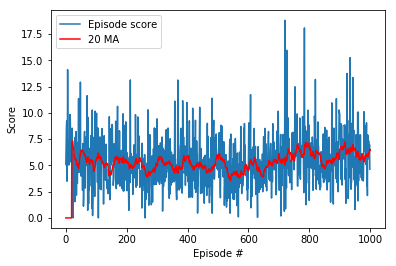

In [22]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

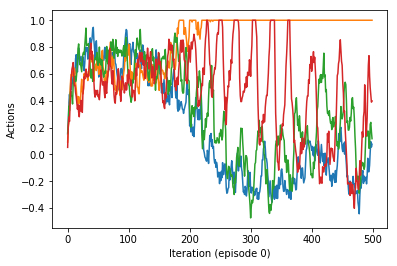

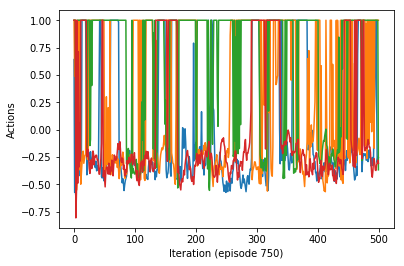

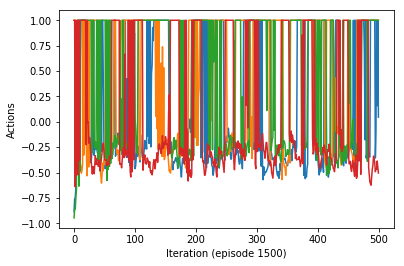

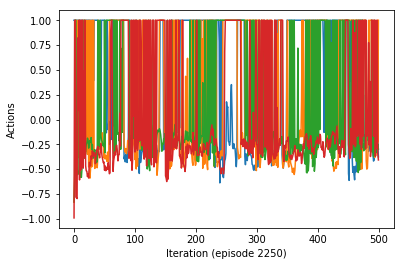

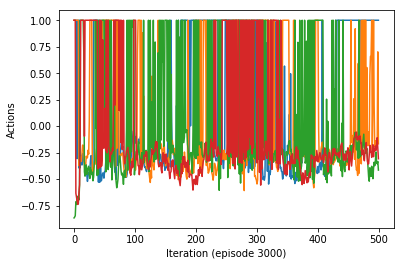

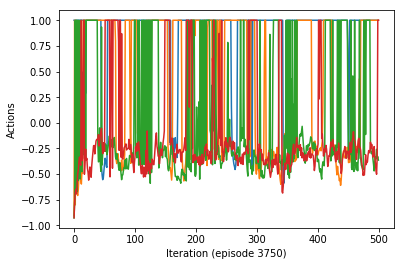

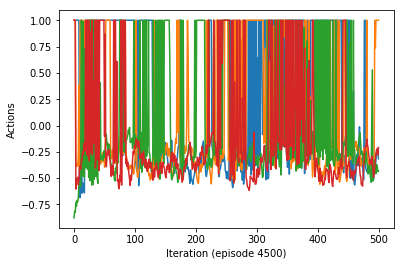

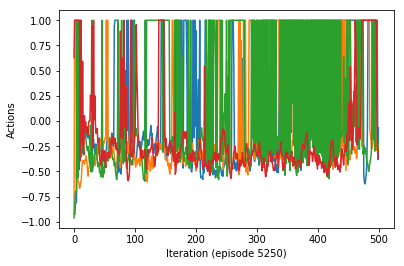

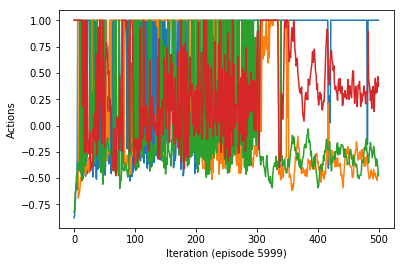

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [24]:
scores = ddpg(agent, env, 30, 500, 1000)

Episode 1	Score: 16.30	Average Score: 16.30	Actions: [-0.3960969   1.          1.          0.25394267]
Episode 2	Score: 12.39	Average Score: 14.34	Actions: [ 1.         -0.3184613  -0.24407509  0.303708  ]
Episode 3	Score: 11.57	Average Score: 13.42	Actions: [ 0.69835955  1.         -0.19143762 -0.34472805]
Episode 4	Score: 7.02	Average Score: 11.82	Actions: [-0.38105738 -0.40112373  1.          0.06555185]
Episode 5	Score: 12.85	Average Score: 12.03	Actions: [-0.29645714  1.         -0.1776853  -0.36778393]
Episode 6	Score: 11.60	Average Score: 11.95	Actions: [-0.47766393 -0.15306732 -0.19509193  1.        ]
Episode 7	Score: 13.70	Average Score: 12.20	Actions: [ 1.         -0.34686342  1.          0.6856476 ]
Episode 8	Score: 8.58	Average Score: 11.75	Actions: [-0.1974864  -0.30155793 -0.35678405 -0.12936032]
Episode 9	Score: 10.77	Average Score: 11.64	Actions: [-0.3877129   1.         -0.21415745 -0.46893293]
Episode 10	Score: 13.27	Average Score: 11.80	Actions: [-0.09663758  1.     

Episode 81	Score: 15.36	Average Score: 11.18	Actions: [ 1.         -0.353868    1.         -0.43648198]
Episode 82	Score: 12.37	Average Score: 11.19	Actions: [-0.42805585  1.         -0.25670373 -0.13391505]
Episode 83	Score: 11.05	Average Score: 11.19	Actions: [ 1.         -0.18891875 -0.4677557   0.8157573 ]
Episode 84	Score: 16.32	Average Score: 11.25	Actions: [ 1.          1.         -0.27274457 -0.29792136]
Episode 85	Score: 10.73	Average Score: 11.24	Actions: [-0.41035375 -0.25088647 -0.30964965 -0.42101273]
Episode 86	Score: 17.15	Average Score: 11.31	Actions: [1.         0.05240805 1.         0.23077199]
Episode 87	Score: 29.32	Average Score: 11.52	Actions: [-0.08760755 -0.36658427 -0.27206716  1.        ]
Episode 88	Score: 15.79	Average Score: 11.57	Actions: [-0.38672048  1.         -0.3939703   0.4493377 ]
Episode 89	Score: 14.98	Average Score: 11.61	Actions: [-0.4352133  -0.35056904 -0.30967528  1.        ]
Episode 90	Score: 24.17	Average Score: 11.75	Actions: [ 0.2319885  -

Episode 160	Score: 17.45	Average Score: 12.28	Actions: [ 1.         -0.252253    1.         -0.16245675]
Episode 161	Score: 19.36	Average Score: 12.38	Actions: [ 1.          0.2540457  -0.2701729  -0.37967634]
Episode 162	Score: 12.17	Average Score: 12.39	Actions: [ 1.         -0.46475464 -0.1005156   1.        ]
Episode 163	Score: 10.52	Average Score: 12.42	Actions: [-0.37298423  1.         -0.48183268 -0.2698803 ]
Episode 164	Score: 8.72	Average Score: 12.46	Actions: [-0.43100512 -0.20848213 -0.47828826 -0.32985952]
Episode 165	Score: 15.04	Average Score: 12.39	Actions: [-0.47715992 -0.45745233 -0.40341935  0.3567249 ]
Episode 166	Score: 15.32	Average Score: 12.47	Actions: [-0.36303794  1.         -0.3834627  -0.34171718]
Episode 167	Score: 23.23	Average Score: 12.57	Actions: [ 1.         -0.46153307  0.78169405 -0.13553932]
Episode 168	Score: 4.77	Average Score: 12.47	Actions: [-0.24572887 -0.2947997  -0.3548755   0.38652086]
Episode 169	Score: 7.41	Average Score: 12.44	Actions: [-0

Episode 239	Score: 15.19	Average Score: 10.75	Actions: [-0.11987736 -0.52032113 -0.3378086   1.        ]
Episode 240	Score: 12.12	Average Score: 10.83	Actions: [ 1.         -0.49850425 -0.4751978  -0.14643401]
Episode 241	Score: 9.28	Average Score: 10.78	Actions: [-0.36726847  1.         -0.20380712 -0.30475247]
Episode 242	Score: 4.13	Average Score: 10.67	Actions: [ 1.         -0.43113494  1.         -0.33904672]
Episode 243	Score: 12.69	Average Score: 10.69	Actions: [-0.13289228  0.62341994 -0.46251342  1.        ]
Episode 244	Score: 16.01	Average Score: 10.75	Actions: [-0.0822644  -0.3971002  -0.36393622 -0.31175268]
Episode 245	Score: 11.66	Average Score: 10.77	Actions: [-0.45673794  1.          1.         -0.12783313]
Episode 246	Score: 8.90	Average Score: 10.74	Actions: [ 1.         -0.28375214 -0.19516635  1.        ]
Episode 247	Score: 10.49	Average Score: 10.77	Actions: [-0.5261271  1.        -0.5273541  1.       ]
Episode 248	Score: 13.74	Average Score: 10.84	Actions: [-0.275

Episode 317	Score: 19.89	Average Score: 12.91	Actions: [ 1.         -0.21335088  1.         -0.21835493]
Episode 318	Score: 15.06	Average Score: 12.97	Actions: [ 1.          1.         -0.2558041   0.33270657]
Episode 319	Score: 10.94	Average Score: 12.96	Actions: [-0.24053125  1.         -0.28221303 -0.29939055]
Episode 320	Score: 6.83	Average Score: 12.86	Actions: [-0.26689848  1.          1.         -0.21665573]
Episode 321	Score: 11.02	Average Score: 12.85	Actions: [ 1.        -0.4996362  1.        -0.2365439]
Episode 322	Score: 11.62	Average Score: 12.86	Actions: [ 1.          1.         -0.18489638  1.        ]
Episode 323	Score: 16.00	Average Score: 12.85	Actions: [-0.41317984 -0.3385033   1.          0.45179355]
Episode 324	Score: 3.98	Average Score: 12.87	Actions: [ 1.         -0.21519674 -0.49342865  1.        ]
Episode 325	Score: 11.09	Average Score: 12.87	Actions: [ 1.         1.        -0.5010355  1.       ]
Episode 326	Score: 15.04	Average Score: 12.88	Actions: [-0.297441

Episode 396	Score: 6.89	Average Score: 11.77	Actions: [-0.49886116  0.02777377 -0.29667377 -0.06228703]
Episode 397	Score: 13.50	Average Score: 11.86	Actions: [-0.25802857 -0.2307627  -0.47066736 -0.38441533]
Episode 398	Score: 12.62	Average Score: 11.83	Actions: [-0.35580993  1.         -0.36100066 -0.23992918]
Episode 399	Score: 15.61	Average Score: 11.78	Actions: [-0.35362366 -0.48962164 -0.38940287 -0.00482067]
Episode 400	Score: 12.60	Average Score: 11.69	Actions: [-0.22138992  1.          0.3677926   0.9109453 ]
Episode 400	Average Score: 11.69
Episode 401	Score: 17.99	Average Score: 11.70	Actions: [-0.4512394  -0.15373902 -0.41600332 -0.20016661]
Episode 402	Score: 18.53	Average Score: 11.67	Actions: [-0.14033942  0.664876   -0.37167534 -0.21933167]
Episode 403	Score: 9.38	Average Score: 11.69	Actions: [ 1.         -0.34346282  0.7751862   0.0357396 ]
Episode 404	Score: 12.16	Average Score: 11.65	Actions: [ 1.         1.        -0.2798524 -0.298515 ]
Episode 405	Score: 13.89	Ave

Episode 475	Score: 14.74	Average Score: 12.03	Actions: [ 1.          0.3327062   1.         -0.09492676]
Episode 476	Score: 11.91	Average Score: 12.08	Actions: [-0.45777768 -0.32735693 -0.08622819 -0.22614609]
Episode 477	Score: 7.65	Average Score: 12.03	Actions: [ 1.         -0.12100448  1.         -0.47190526]
Episode 478	Score: 3.93	Average Score: 11.92	Actions: [ 1.         -0.41956958 -0.3342647   0.10646344]
Episode 479	Score: 16.99	Average Score: 11.94	Actions: [ 1.          1.         -0.3653839  -0.07582597]
Episode 480	Score: 12.70	Average Score: 11.96	Actions: [ 1.         -0.44272378 -0.1681488   1.        ]
Episode 481	Score: 16.10	Average Score: 12.03	Actions: [ 1.         -0.23187016 -0.29404682  0.3057549 ]
Episode 482	Score: 7.51	Average Score: 12.01	Actions: [ 1.         -0.2621078   1.         -0.37201795]
Episode 483	Score: 8.86	Average Score: 12.01	Actions: [ 1.         -0.29459414 -0.56729364 -0.37887955]
Episode 484	Score: 10.79	Average Score: 11.96	Actions: [ 1.

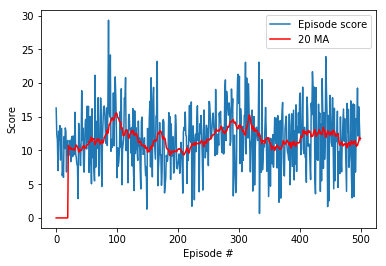

In [25]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

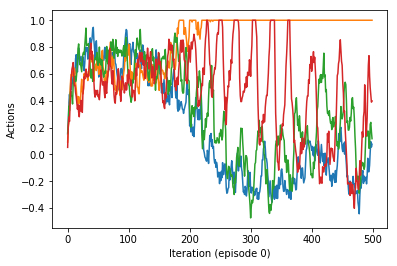

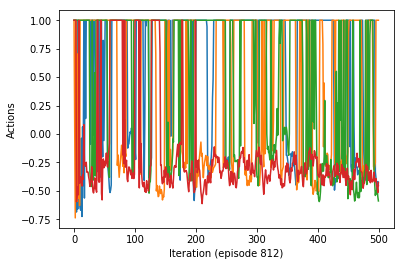

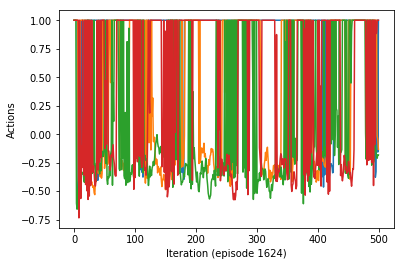

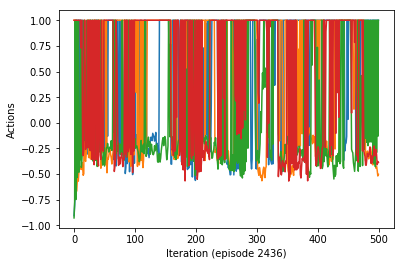

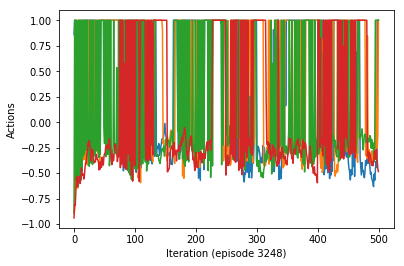

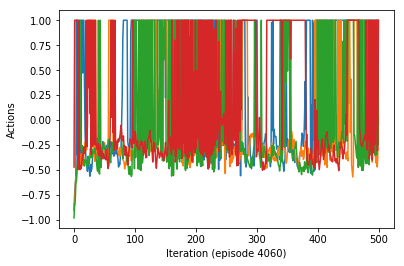

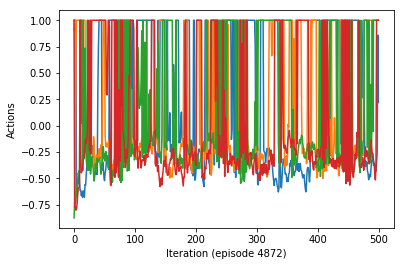

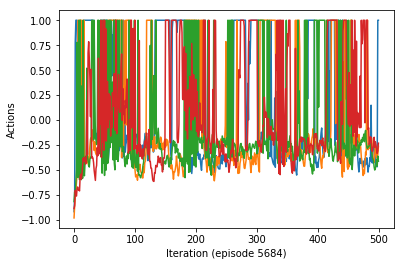

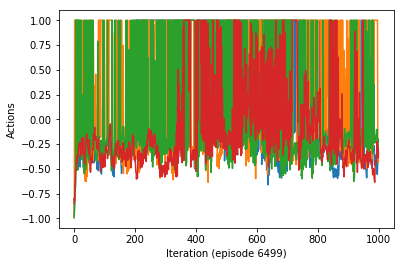

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [27]:
scores = ddpg(agent, env, 30, 500, 1000)

Episode 1	Score: 9.54	Average Score: 9.54	Actions: [-0.10968449 -0.28793958 -0.41542903 -0.4455908 ]
Episode 2	Score: 7.38	Average Score: 8.46	Actions: [-0.39486444 -0.3454833  -0.41007537 -0.42939535]
Episode 3	Score: 8.95	Average Score: 8.62	Actions: [-0.42294767 -0.2525455  -0.536078    0.33270955]
Episode 4	Score: 12.96	Average Score: 9.71	Actions: [-0.394126   1.        -0.4417908  0.7870858]
Episode 5	Score: 11.37	Average Score: 10.04	Actions: [ 1.         -0.22413418 -0.45292598  1.        ]
Episode 6	Score: 12.69	Average Score: 10.48	Actions: [-0.31496888  1.         -0.44649297 -0.09778591]
Episode 7	Score: 12.59	Average Score: 10.78	Actions: [-0.41935334 -0.19959691 -0.21126655  0.5477574 ]
Episode 8	Score: 10.93	Average Score: 10.80	Actions: [-0.04716546  1.         -0.4135517  -0.2966151 ]
Episode 9	Score: 8.01	Average Score: 10.49	Actions: [-0.18295316 -0.31407937 -0.2810144  -0.32386684]
Episode 10	Score: 5.65	Average Score: 10.01	Actions: [-0.3069494  1.        -0.343310

Episode 81	Score: 6.38	Average Score: 12.42	Actions: [ 1.         -0.28872943 -0.20919858 -0.39109936]
Episode 82	Score: 12.95	Average Score: 12.43	Actions: [-0.31841865  1.         -0.2707368  -0.28861454]
Episode 83	Score: 17.45	Average Score: 12.49	Actions: [ 1.          1.         -0.40618882 -0.06132326]
Episode 84	Score: 7.75	Average Score: 12.43	Actions: [-0.37827212 -0.3527307   1.         -0.2899063 ]
Episode 85	Score: 14.99	Average Score: 12.46	Actions: [-0.24178769 -0.3087534  -0.36800364 -0.2807066 ]
Episode 86	Score: 16.39	Average Score: 12.51	Actions: [ 1.        1.       -0.327164  1.      ]
Episode 87	Score: 10.55	Average Score: 12.49	Actions: [ 1.         -0.31490925 -0.10495007 -0.3597351 ]
Episode 88	Score: 16.59	Average Score: 12.53	Actions: [ 0.87554294  1.         -0.3592874  -0.09916641]
Episode 89	Score: 7.38	Average Score: 12.48	Actions: [-0.27882686 -0.21933481 -0.28816035  1.        ]
Episode 90	Score: 11.90	Average Score: 12.47	Actions: [ 1.          0.48909

Episode 160	Score: 15.43	Average Score: 11.52	Actions: [ 1.         -0.31049514 -0.2419495   1.        ]
Episode 161	Score: 13.11	Average Score: 11.54	Actions: [ 1.          1.         -0.27865183 -0.2602488 ]
Episode 162	Score: 16.31	Average Score: 11.59	Actions: [-0.23085058 -0.38505164 -0.39428574 -0.35136297]
Episode 163	Score: 17.24	Average Score: 11.70	Actions: [ 1.         -0.18204384 -0.2152774  -0.27822816]
Episode 164	Score: 15.72	Average Score: 11.71	Actions: [-0.26750702 -0.50186485 -0.26594797 -0.31937757]
Episode 165	Score: 8.98	Average Score: 11.74	Actions: [-0.5385788   1.         -0.46387678 -0.06839932]
Episode 166	Score: 12.29	Average Score: 11.84	Actions: [-0.22210388 -0.26058766 -0.44349536 -0.31884667]
Episode 167	Score: 6.91	Average Score: 11.78	Actions: [-0.43847668  1.         -0.30290908 -0.27385724]
Episode 168	Score: 19.66	Average Score: 11.80	Actions: [-0.15583225 -0.24513642 -0.41101208 -0.55197203]
Episode 169	Score: 15.22	Average Score: 11.77	Actions: [-

Episode 238	Score: 3.82	Average Score: 12.30	Actions: [1.         1.         1.         0.04224506]
Episode 239	Score: 8.23	Average Score: 12.28	Actions: [-0.41294882 -0.42324176 -0.30077964  1.        ]
Episode 240	Score: 11.78	Average Score: 12.35	Actions: [ 1.        -0.5250007  1.        -0.2567162]
Episode 241	Score: 8.40	Average Score: 12.37	Actions: [ 1.         -0.23593254  1.          1.        ]
Episode 242	Score: 11.97	Average Score: 12.39	Actions: [ 1.          0.3743294  -0.42136407  0.47429442]
Episode 243	Score: 15.13	Average Score: 12.43	Actions: [-0.50337934  1.         -0.27708495 -0.22501536]
Episode 244	Score: 6.41	Average Score: 12.35	Actions: [ 0.3380869  -0.46361935 -0.3550697  -0.3635482 ]
Episode 245	Score: 10.76	Average Score: 12.43	Actions: [ 1.         -0.23827966  1.         -0.15306485]
Episode 246	Score: 7.55	Average Score: 12.39	Actions: [-0.24628143  1.          1.         -0.27700365]
Episode 247	Score: 11.65	Average Score: 12.36	Actions: [ 1.         

Episode 316	Score: 21.73	Average Score: 13.13	Actions: [ 1.         -0.2737564  -0.30715787 -0.27167454]
Episode 317	Score: 21.03	Average Score: 13.14	Actions: [-0.3353103   1.         -0.12469497  1.        ]
Episode 318	Score: 12.39	Average Score: 13.13	Actions: [ 1.         -0.29167873 -0.34334454 -0.11858382]
Episode 319	Score: 12.62	Average Score: 13.10	Actions: [ 1.       -0.202558  1.        1.      ]
Episode 320	Score: 16.67	Average Score: 13.10	Actions: [ 1.          1.         -0.30021426  0.57511336]
Episode 321	Score: 11.91	Average Score: 13.10	Actions: [-0.2350422  -0.3201124  -0.41329458 -0.48406738]
Episode 322	Score: 7.86	Average Score: 13.08	Actions: [-0.2534892  -0.47500798  1.         -0.28323776]
Episode 323	Score: 11.09	Average Score: 13.10	Actions: [ 1.         -0.16437802  1.          1.        ]
Episode 324	Score: 14.16	Average Score: 13.08	Actions: [-0.1154126  1.         1.         1.       ]
Episode 325	Score: 17.31	Average Score: 13.11	Actions: [ 1.         

Episode 395	Score: 13.87	Average Score: 13.35	Actions: [ 1.         -0.36415434  1.         -0.19705415]
Episode 396	Score: 12.49	Average Score: 13.26	Actions: [ 1.         -0.25662097  1.         -0.33395767]
Episode 397	Score: 15.86	Average Score: 13.22	Actions: [-0.20061189 -0.37684718 -0.34559807  1.        ]
Episode 398	Score: 12.06	Average Score: 13.16	Actions: [-0.06144176  1.         -0.41257623  0.02296869]
Episode 399	Score: 21.23	Average Score: 13.22	Actions: [ 1.          1.         -0.07610817  0.05742008]
Episode 400	Score: 9.97	Average Score: 13.21	Actions: [ 1.         -0.49881765 -0.09519063 -0.30661893]
Episode 400	Average Score: 13.21
Episode 401	Score: 12.43	Average Score: 13.13	Actions: [ 1.          1.         -0.49619558  0.76123184]
Episode 402	Score: 18.45	Average Score: 13.25	Actions: [-0.30874154  0.82554644 -0.31004533 -0.05474272]
Episode 403	Score: 9.41	Average Score: 13.17	Actions: [ 1.         -0.22716217 -0.29954967 -0.61071706]
Episode 404	Score: 19.44

Episode 474	Score: 22.61	Average Score: 14.84	Actions: [ 1.         -0.33028018  1.         -0.44696185]
Episode 475	Score: 20.13	Average Score: 14.93	Actions: [ 1.          1.         -0.36328578 -0.34331462]
Episode 476	Score: 16.87	Average Score: 15.03	Actions: [-0.40919083  1.         -0.33634946  0.40323314]
Episode 477	Score: 36.01	Average Score: 15.30	Actions: [ 1.         -0.2784178  -0.12274447 -0.06179073]
Episode 478	Score: 6.26	Average Score: 15.30	Actions: [-0.32353565 -0.22026424  1.         -0.4111667 ]
Episode 479	Score: 17.97	Average Score: 15.38	Actions: [-0.17265202 -0.25906345 -0.37609205  1.        ]
Episode 480	Score: 13.31	Average Score: 15.45	Actions: [-0.20024206 -0.2396147  -0.21455854  0.9976971 ]
Episode 481	Score: 20.80	Average Score: 15.57	Actions: [ 1.         -0.41616347  1.          1.        ]
Episode 482	Score: 14.42	Average Score: 15.59	Actions: [-0.2635784   1.         -0.1846727   0.44973683]
Episode 483	Score: 15.56	Average Score: 15.66	Actions: [

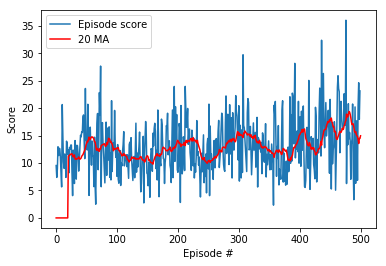

In [28]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

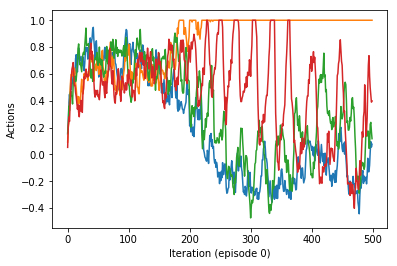

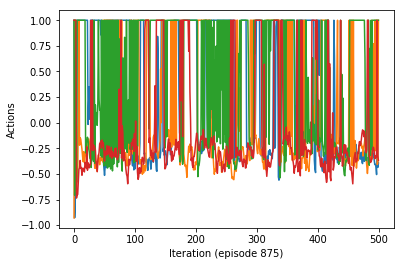

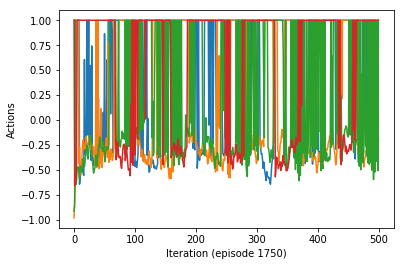

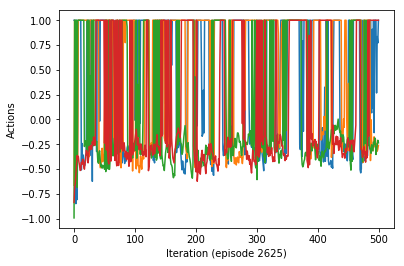

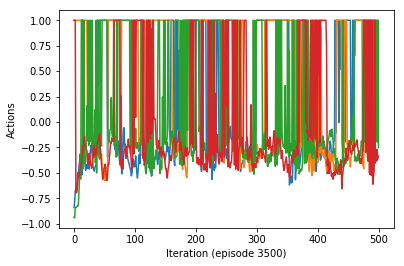

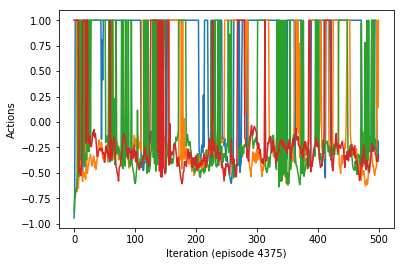

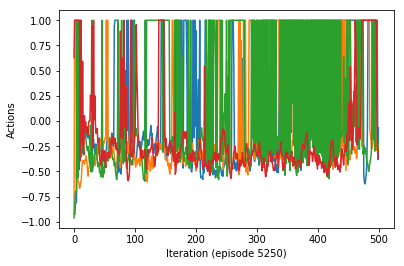

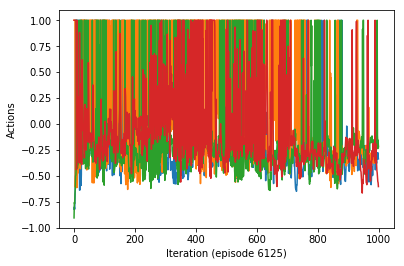

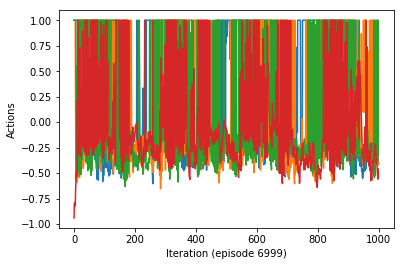

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()

In [30]:
scores = ddpg(agent, env, 30, 500, 1000)

Episode 1	Score: 17.08	Average Score: 17.08	Actions: [-0.28897098 -0.29464906 -0.18218528  0.0318428 ]
Episode 2	Score: 7.97	Average Score: 12.52	Actions: [-0.33838955  1.          1.         -0.2054307 ]
Episode 3	Score: 14.75	Average Score: 13.27	Actions: [-0.36038855 -0.26312596 -0.28762066 -0.05945976]
Episode 4	Score: 8.13	Average Score: 11.98	Actions: [-0.42141125 -0.33104894 -0.27006224 -0.24139301]
Episode 5	Score: 14.97	Average Score: 12.58	Actions: [-0.3484686   1.         -0.15528272 -0.46610346]
Episode 6	Score: 10.86	Average Score: 12.29	Actions: [-0.40292728  1.         -0.30720648  1.        ]
Episode 7	Score: 19.59	Average Score: 13.34	Actions: [-0.33451548  1.         -0.34668338 -0.0550339 ]
Episode 8	Score: 21.64	Average Score: 14.37	Actions: [-0.36305904 -0.40501004 -0.3544766  -0.18658988]
Episode 9	Score: 12.92	Average Score: 14.21	Actions: [-0.35467404 -0.4734663  -0.32566503  1.        ]
Episode 10	Score: 20.85	Average Score: 14.88	Actions: [-0.24941723  1.     

Episode 80	Score: 24.45	Average Score: 15.23	Actions: [ 1.         -0.25095484 -0.33149326  0.02577979]
Episode 81	Score: 11.74	Average Score: 15.19	Actions: [-0.41965702  1.         -0.33397636  0.52584815]
Episode 82	Score: 18.65	Average Score: 15.23	Actions: [ 1.         -0.420717   -0.3304961  -0.06906194]
Episode 83	Score: 18.68	Average Score: 15.27	Actions: [ 1.         -0.44648096 -0.4617225  -0.309741  ]
Episode 84	Score: 10.45	Average Score: 15.21	Actions: [-0.2954972  -0.23346522 -0.22217105 -0.15742639]
Episode 85	Score: 8.76	Average Score: 15.14	Actions: [ 1.         1.         1.        -0.3895338]
Episode 86	Score: 7.60	Average Score: 15.05	Actions: [ 1.         -0.5065073   1.         -0.27156878]
Episode 87	Score: 16.22	Average Score: 15.06	Actions: [ 1.         -0.20301013 -0.53829944 -0.06138348]
Episode 88	Score: 8.86	Average Score: 14.99	Actions: [ 0.1824452   1.         -0.16011202 -0.05532744]
Episode 89	Score: 10.97	Average Score: 14.95	Actions: [ 1.         -0.1

Episode 158	Score: 15.20	Average Score: 14.81	Actions: [-0.28156343 -0.22571246 -0.57412356  0.09069203]
Episode 159	Score: 6.37	Average Score: 14.76	Actions: [ 1.         -0.11474583 -0.29554716 -0.28728163]
Episode 160	Score: 10.98	Average Score: 14.71	Actions: [ 1.          1.         -0.23515512  0.59294415]
Episode 161	Score: 14.94	Average Score: 14.75	Actions: [ 0.31685743  1.         -0.5968236  -0.22519036]
Episode 162	Score: 18.37	Average Score: 14.80	Actions: [ 0.2304942   1.         -0.3550111  -0.28992644]
Episode 163	Score: 11.16	Average Score: 14.68	Actions: [-0.48546115 -0.38883686 -0.36979637  1.        ]
Episode 164	Score: 14.94	Average Score: 14.68	Actions: [-0.24908301 -0.3901173  -0.3662419  -0.08089659]
Episode 165	Score: 17.91	Average Score: 14.68	Actions: [-0.25646824 -0.28657725 -0.24517861  0.11850438]
Episode 166	Score: 10.85	Average Score: 14.58	Actions: [ 1.         -0.2668106  -0.35142875 -0.18176247]
Episode 167	Score: 14.88	Average Score: 14.59	Actions: [

Episode 237	Score: 20.69	Average Score: 15.64	Actions: [ 0.194711   -0.29224038  1.         -0.26403707]
Episode 238	Score: 15.60	Average Score: 15.64	Actions: [ 1.         -0.4034663   0.43584514 -0.1842646 ]
Episode 239	Score: 12.16	Average Score: 15.51	Actions: [-0.39736173  1.         -0.27257493  1.        ]
Episode 240	Score: 12.74	Average Score: 15.56	Actions: [-0.3758234  -0.26085547 -0.2843497   0.4294271 ]
Episode 241	Score: 23.01	Average Score: 15.62	Actions: [ 1.          1.          0.44564617 -0.11363325]
Episode 242	Score: 15.18	Average Score: 15.53	Actions: [-0.38507676 -0.400743    1.         -0.15352868]
Episode 243	Score: 15.27	Average Score: 15.52	Actions: [-0.3052697   1.         -0.28765246 -0.15568575]
Episode 244	Score: 20.57	Average Score: 15.54	Actions: [-0.29907003  1.         -0.18663484  0.80984414]
Episode 245	Score: 21.55	Average Score: 15.61	Actions: [ 1.          1.          0.85678846 -0.21307993]
Episode 246	Score: 11.03	Average Score: 15.52	Actions: 

KeyboardInterrupt: 

In [ ]:
avg = moving_average(scores, ma)
avg = np.concatenate((np.zeros(ma), avg))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode score')
plt.plot(np.arange(len(avg)), avg, c='r', label='{} MA'.format(ma))

plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

size = len(episode_actions)
parts = int(size/8.0)

for i in range(8):
    index = max(0, min(size, i*parts))
    plt.plot(episode_actions[index])
    plt.ylabel('Actions')
    plt.xlabel('Iteration (episode {})'.format(index))
    plt.show()

plt.plot(episode_actions[size-1])
plt.ylabel('Actions')
plt.xlabel('Iteration (episode {})'.format(size-1))
plt.show()